In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

#o/p in daraframe
from sklearn import set_config
set_config(transform_output="pandas")










import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
import scipy.stats as stats
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import IsolationForest
import missingno as msno
from collections import defaultdict
from scipy.stats import chi2_contingency

# Reading data 

In [2]:
df = pd.read_csv(r'C:\Users\ABC\Desktop/bhushan/property_project/data/property_cleaned_data.csv')

In [3]:
df.head()

id                      builder                 project_name  \
0  cardid69429251               raymond realty  tenx habitat raymond realty   
1  cardid69427147               paradise group    paradise sai world empire   
2  cardid71764335  n rose developers pvt. ltd.               northern hills   
3  cardid71631505                  avant group             avant heritage v   
4  cardid72558997                      mj shah                    centrionx   

   project_in_acres         location         city  lattitude  longitude  \
0            1.3006     pokhran road        thane  19.207777  72.967479   
1           17.0000         kharghar  navi mumbai  19.080605  73.073939   
2            1.0000     dahisar east       mumbai  19.248778  72.863793   
3            1.0000  jogeshwari east       mumbai  19.138704  72.859964   
4            2.0000          govandi       mumbai  19.055308  72.922850   

  property_type              status  ... hospital_within_2km tourist_mean_km  \
0  new property  under construction  ...                 NaN             NaN   
1  new property  under construction  ...                 NaN             NaN   
2  new property  under construction  ...                 NaN             NaN   
3  new property  under construction  ...                 NaN             NaN   
4  new property  under construction  ...                 NaN             NaN   

   tourist_min_km  tourist_within_2km overall_min_mean_km  \
0             NaN                 NaN            1.833333   
1             NaN                 NaN            2.760000   
2             NaN                 NaN            5.380000   
3             NaN                 NaN                 NaN   
4             NaN                 NaN            1.200000   

   overall_avg_mean_km  overall_min_min_km  overall_avg_min_km  \
0             3.044444                 1.2            2.100000   
1             3.980000                 1.1            1.900000   
2            10.417917                 0.2            4.900000   
3                  NaN                 NaN                 NaN   
4             2.370000                 1.2            1.566667   

   total_within_2km           seller  
0               2.0     organization  
1               2.0  realestateagent  
2               8.0     organization  
3               0.0     organization  
4               4.0     organization  

[5 rows x 55 columns]

# Functions

`overview of data types, unique counts, and missing values`

In [4]:
def null_features(df):
    # Prepare dataset EDA values
    summary = pd.DataFrame(df.dtypes, columns=['dtypes']).reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]

    # Function to safely count uniques, ignoring columns with unhashable types (like lists)
    def safe_nunique(col):
        try:
            return col.nunique()
        except TypeError:
            return None  # or np.nan if you prefer

    # Calculate uniques with safe check
    summary['Uniques'] = summary['Name'].apply(lambda col_name: safe_nunique(df[col_name]))
    summary['Null'] = df.isna().sum().values
    summary['Null(%)'] = round((summary['Null'] / len(df) * 100), 1).astype(str) + '%'

    # Add a column to indicate whether the feature has missing values
    summary['Has Null'] = summary['Null'] > 0

    # Sort by Null count (descending) and Name (ascending)
    summary = summary.sort_values(by=['Null', 'Name'], ascending=[False, True]).reset_index(drop=True)
    summary.index = range(1, len(summary) + 1)

    return summary


`Categorization of Hidden Patterns in Missing Data Using Correlation Matrix Analysis`

In [5]:
def categorize_missingness(corr_matrix):
    categories = {
        "exact 1.00 means always Missing Together": defaultdict(list),
        "less than 1.00 but greater than equal to 0.7 means highly Likely to be Missing Together": defaultdict(list),
        "less than 0.7 but greater than equal to 0.4 means moderately Related Missingness": defaultdict(list),
        "less than 0.4 but greater than equal to 0.1 means occasionally Missing Together": defaultdict(list),
        "less than -0.7 means one Present, one Always Missing": defaultdict(list),
        "less than -0.4 but greater than equal to -0.7 means highly Opposite Missingness": defaultdict(list),
        "less than -0.1 but greater than equal to -0.4 means slightly Opposite Missingness": defaultdict(list),
        "between -0.1 and 0.1 means unrelated Missingness": defaultdict(list)
    }

    processed_pairs = set()

    for col in corr_matrix.columns:
        for index, corr_value in corr_matrix[col].items():
            if col != index and (index, col) not in processed_pairs:
                processed_pairs.add((col, index))  # Mark as processed to avoid duplicates

                if corr_value == 1.0:
                    categories["exact 1.00 means always Missing Together"][col].append(index)
                elif corr_value >= 0.7:
                    categories["less than 1.00 but greater than equal to 0.7 means highly Likely to be Missing Together"][col].append(index)
                elif corr_value >= 0.4:
                    categories["less than 0.7 but greater than equal to 0.4 means moderately Related Missingness"][col].append(index)
                elif corr_value >= 0.1:
                    categories["less than 0.4 but greater than equal to 0.1 means occasionally Missing Together"][col].append(index)
                elif corr_value <= -0.7:
                    categories["less than -0.7 means one Present, one Always Missing"][col].append(index)
                elif corr_value <= -0.4:
                    categories["less than -0.4 but greater than equal to -0.7 means highly Opposite Missingness"][col].append(index)
                elif corr_value <= -0.1:
                    categories["less than -0.1 but greater than equal to -0.4 means slightly Opposite Missingness"][col].append(index)
                else:
                    categories["between -0.1 and 0.1 means unrelated Missingness"][col].append(index)

    return categories

# Compute missing value correlation matrix
missing_corr_matrix = df.isnull().corr()

`Tagline: Identify potential relationships by ranking mean differences for missing vs. non-missing groups.`

In [6]:
def analyze_missing_column(X_train, column):
    """Analyzes missing vs. non-missing groups for a given column and sorts absolute differences."""
    
    # Split data
    missing_data = X_train[X_train[column].isnull()]
    not_missing_data = X_train[~X_train[column].isnull()]
    
    # Calculate means for numeric columns
    means_missing = missing_data.select_dtypes(include=['number']).mean()
    means_not_missing = not_missing_data.select_dtypes(include=['number']).mean()
    
    # Compute absolute differences
    mean_differences = abs(means_missing - means_not_missing)
    
    # Sort differences in descending order
    sorted_differences = mean_differences.sort_values(ascending=False)
    
    print(f"Means with '{column}' missing:\n", means_missing)
    print(f"\nMeans without '{column}' missing:\n", means_not_missing)
    print(f"\nAbsolute Differences (Sorted):\n", sorted_differences)

# Example Usage
# analyze_missing_column(X_train, 'parking')

`Detect missingness pattern (MCAR vs MAR) with t-tests for all numeric predictors.`

In [7]:
def analyze_missing_column_with_all_predictors(X_train, column, alpha=0.05):
    """
    Performs t-tests between missing and non-missing groups for the given column,
    using all other numerical predictor columns.
    Prints summary counts for MAR and MCAR.
    """
    # Identify numerical columns except the target column
    numerical_cols = X_train.select_dtypes(include='number').columns.tolist()
    predictor_cols = [col for col in numerical_cols if col != column]

    # Split data into missing and non-missing groups
    missing_data = X_train[X_train[column].isnull()]
    not_missing_data = X_train[~X_train[column].isnull()]

    mar_count = 0
    mcar_count = 0

    for test_col in predictor_cols:
        # Extract valid (non-NaN) values
        group1 = missing_data[test_col].dropna()
        group2 = not_missing_data[test_col].dropna()
    
        # Skip if either group has fewer than 2 samples or zero variance
        if len(group1) < 2 or len(group2) < 2:
            print(f"\nSkipping '{test_col}': Not enough data in one of the groups.")
            continue
        if np.std(group1) == 0 or np.std(group2) == 0:
            print(f"\nSkipping '{test_col}': Zero variance in one of the groups.")
            continue
    
        # Use the clean groups!
        t_stat, p_val = ttest_ind(
            group1, group2,
            equal_var=False, nan_policy='omit'
        )
    
        print(f"\nT-test for '{test_col}':")
        print(f"T-statistic: {t_stat:.4f}, P-value: {p_val:.4f}")
    
        if p_val < alpha:
            print(f"=> '{test_col}' is significantly different: '{column}' likely MAR.")
            mar_count += 1
        else:
            print(f"=> '{test_col}' is NOT significantly different: '{column}' likely MCAR.")
            mcar_count += 1

    print("\n=== Final Summary ===")
    print(f"Total predictors tested: {len(predictor_cols)}")
    print(f"MAR count: {mar_count}")
    print(f"MCAR count: {mcar_count}")
    print("Note: MNAR cannot be detected by this test; it requires domain knowledge or pattern detection.")

# Example usage:
# analyze_missing_column_with_all_predictors(X_train, 'parking')

`Predictive Modeling for Missingness`

In [8]:
def missingness_logistic_test(df, pattern_for_column, drop_columns=None):
    
    # Work on a copy
    df_copy = df.copy()

    # Create missingness indicator
    missing_col = f"{pattern_for_column}_missing"
    df_copy[missing_col] = df_copy[pattern_for_column].isnull().astype(int)

    # Select numeric features
    num_features = df_copy.select_dtypes(include=['number']).columns.tolist()

    # Drop target, missing indicator, and any user-specified columns
    drop_cols = [pattern_for_column, missing_col]
    if drop_columns:
        drop_cols.extend(drop_columns)

    X = df_copy[num_features].drop(columns=drop_cols, errors='ignore')
    y = df_copy[missing_col]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Impute missing
    imputer = SimpleImputer(strategy='median')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # Scale
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    if len(y_train.unique()) < 2:
        print(f"Cannot run logistic regression: only one class ({y_train.unique()[0]}) found in training data for '{pattern_for_column}'.")
        return

    # Fit logistic regression
    model = LogisticRegression(max_iter=1000, class_weight='balanced')
    model.fit(X_train, y_train)

    # Predict and report
    predictions = model.predict(X_test)
    print(f"Missingness pattern for '{pattern_for_column}':")
    print(classification_report(y_test, predictions))


`missingness in a categorical column using chi-square test`

In [9]:
def analyze_missingness_for_categorical(df, target_col, alpha=0.05):
    # Create missingness indicator (0 = not missing, 1 = missing)
    missing_indicator = df[target_col].isnull().astype(int)

    # Get all other categorical columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    predictor_cols = [col for col in cat_cols if col != target_col]

    if missing_indicator.sum() == 0:
        print(f"✅ No missing values in '{target_col}'")
        return

    mar_count = 0
    mcar_count = 0

    for col in predictor_cols:
        # Build contingency table
        contingency_table = pd.crosstab(df[col], missing_indicator)

        if contingency_table.shape[0] < 2:
            print(f"\nSkipping '{col}': Not enough categories to test.")
            continue

        chi2, p, dof, expected = chi2_contingency(contingency_table)

        print(f"\nChi-square test for '{col}':")
        print(f"Chi2 statistic: {chi2:.4f}, P-value: {p:.4f}")

        if p < alpha:
            print(f"=> '{col}' is significantly related: '{target_col}' likely MAR.")
            mar_count += 1
        else:
            print(f"=> '{col}' is NOT significantly related: '{target_col}' likely MCAR.")
            mcar_count += 1

    print("\n=== Final Summary ===")
    print(f"Total predictors tested: {len(predictor_cols)}")
    print(f"MAR count: {mar_count}")
    print(f"MCAR count: {mcar_count}")
    print("Note: MNAR needs domain knowledge or patterns — not detectable via Chi-square alone.")

# ================================
# ✅ Example usage:
# analyze_missingness_for_categorical(df, 'your_categorical_column')

In [10]:
#total no of missing values in data

df.isna().sum().sum()

198867

In [11]:
# percentage of rows in the data having missing value

(df.isna().any(axis=1).sum() / df.shape[0]) * 100

99.96626465379101

`observation`
- 150528 is a big number that tells us there are a lot of missing values in dataset
- almost all rows have atleast one or more than one missing values 

In [12]:
null_features(df)

Name   dtypes  Uniques   Null Null(%)  Has Null
1              tourist_mean_km  float64       12  10357   87.3%      True
2               tourist_min_km  float64       10  10357   87.3%      True
3           tourist_within_2km  float64        4  10306   86.9%      True
4             hospital_mean_km  float64       29   8671   73.1%      True
5              hospital_min_km  float64       19   8671   73.1%      True
6          hospital_within_2km  float64        5   8564   72.2%      True
7            transport_mean_km  float64       93   6233   52.6%      True
8             transport_min_km  float64       58   6233   52.6%      True
9                      parking  float64       10   6208   52.4%      True
10        transport_within_2km  float64        6   6055   51.1%      True
11                     balcony  float64        8   5801   48.9%      True
12            project_in_acres  float64      205   5730   48.3%      True
13                        lift  float64       10   5419   45.7%      True
14                 extra_rooms   object       35   5275   44.5%      True
15             available_units  float64      588   5198   43.8%      True
16      commercial_hub_mean_km  float64      110   5121   43.2%      True
17       commercial_hub_min_km  float64       75   5121   43.2%      True
18   commercial_hub_within_2km  float64        6   5116   43.1%      True
19                      towers  float64       42   5005   42.2%      True
20                    flooring   object      252   4430   37.4%      True
21                     builder   object     1143   4255   35.9%      True
22           education_mean_km  float64      141   4242   35.8%      True
23            education_min_km  float64       50   4242   35.8%      True
24        education_within_2km  float64        6   4242   35.8%      True
25                 overlooking   object        7   3945   33.3%      True
26     shopping_centre_mean_km  float64      156   3863   32.6%      True
27      shopping_centre_min_km  float64       53   3863   32.6%      True
28  shopping_centre_within_2km  float64        6   3863   32.6%      True
29                      facing   object        8   3716   31.3%      True
30         overall_avg_mean_km  float64      202   3683   31.1%      True
31          overall_avg_min_km  float64      156   3683   31.1%      True
32         overall_min_mean_km  float64      105   3683   31.1%      True
33          overall_min_min_km  float64       34   3683   31.1%      True
34                   ownership   object        4   3590   30.3%      True
35                project_name   object     2935   3479   29.3%      True
36               flat_on_floor  float64       71   2287   19.3%      True
37                 total_floor  float64       85   2054   17.3%      True
38                construction   object        7   1048    8.8%      True
39                    location   object      901    481    4.1%      True
40                   lattitude  float64     2908    464    3.9%      True
41                   longitude  float64     2844    464    3.9%      True
42                      status   object        3     82    0.7%      True
43                     furnish   object        3     39    0.3%      True
44                        bath  float64       10     30    0.3%      True
45                 costpersqft  float64     7473      6    0.1%      True
46                        area  float64     1517      5    0.0%      True
47                         emi  float64      587      2    0.0%      True
48               property_type   object        2      2    0.0%      True
49                         bed  float64        9      0    0.0%     False
50                        city   object        4      0    0.0%     False
51                          id   object    11857      0    0.0%     False
52                       price  float64     1166      0    0.0%     False
53              price_category   object       13      0    0.0%     False
54                      seller

`observation`
- The columns tourist_mean_km, tourist_min_km, hospital_mean_km, and hospital_min_km have more than 70% missing values. Using a missing indicator for them is also unreasonable; hence, these columns should be deleted.

In [13]:
cols_to_drop = ['tourist_mean_km', 'tourist_min_km', 'hospital_mean_km', 'hospital_min_km']
df = df.drop(columns=cols_to_drop)

# train_test split 

In [14]:
X = df.drop(columns=['price'])
y = df['price']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

`High level analysis of outliers using - Isolation Forest`

so from excel we can go through each column to check outliers

In [16]:
# Step 1: Select numeric columns and drop rows with NaNs
X_num = X_train.select_dtypes(include="number")
X_train_numeric_clean = X_train.loc[X_num.dropna().index]

# Step 2: Fit IsolationForest
forest = IsolationForest(random_state=42)
X_train_numeric_clean = X_train_numeric_clean.assign(
    outlier=forest.fit_predict(X_train_numeric_clean.select_dtypes(include="number"))
)

# Step 3: Filter detected outliers
outliers_df = X_train_numeric_clean.query("outlier == -1")

# Step 4: Save to Excel
outliers_df.to_excel("outliers_output.xlsx", index=False)

`To identify which column(s) might be responsible for a row being flagged as an outlier by IsolationForest, we can follow this structured approach:`

In [17]:
from scipy.stats import zscore

# Compute Z-scores for numeric columns
z_scores = X_train_numeric_clean.select_dtypes(include="number").apply(zscore)

# Add outlier column
z_scores['outlier'] = X_train_numeric_clean['outlier']

# Filter only outliers
outlier_zscores = z_scores.query("outlier == -1").drop(columns='outlier')

# Get average absolute deviation per feature
deviation_summary = outlier_zscores.abs().mean().sort_values(ascending=False)
print(deviation_summary)


project_in_acres             NaN
lattitude                    NaN
longitude                    NaN
flat_on_floor                NaN
total_floor                  NaN
area                         NaN
bed                          NaN
bath                         NaN
balcony                      NaN
lift                         NaN
parking                      NaN
available_units              NaN
towers                       NaN
costpersqft                  NaN
emi                          NaN
education_mean_km            NaN
education_min_km             NaN
education_within_2km         NaN
transport_mean_km            NaN
transport_min_km             NaN
transport_within_2km         NaN
shopping_centre_mean_km      NaN
shopping_centre_min_km       NaN
shopping_centre_within_2km   NaN
commercial_hub_mean_km       NaN
commercial_hub_min_km        NaN
commercial_hub_within_2km    NaN
hospital_within_2km          NaN
tourist_within_2km           NaN
overall_min_mean_km          NaN
overall_av

`Observation`
- Removed NaN values and applied Isolation Forest to check for major outliers.
- The above-listed columns have a high possibility of containing outliers.
- A Z-score tells you how far a value is from the mean in standard deviation units.
So, an average absolute Z-score of 2.17 for emi means that, on average, your outlier points have emi values that are 2.17 standard deviations away from the mean emi.
- Higher is not better: A higher Z-score here just means that feature is contributing more to the point being an outlier
- Checked the outlier rows from the Excel sheet and didn’t find any major issues, so continued with missing value imputation.

In [18]:
X_train.isna().sum().sum()

128924

In [19]:
X_test.isna().sum().sum()

31887

In [20]:
null_features(X_train)

Name   dtypes  Uniques  Null Null(%)  Has Null
1           tourist_within_2km  float64        4  8238   86.9%      True
2          hospital_within_2km  float64        5  6885   72.6%      True
3            transport_mean_km  float64       91  4981   52.5%      True
4             transport_min_km  float64       56  4981   52.5%      True
5                      parking  float64        8  4951   52.2%      True
6         transport_within_2km  float64        6  4833   51.0%      True
7                      balcony  float64        8  4653   49.1%      True
8             project_in_acres  float64      189  4605   48.6%      True
9                         lift  float64       10  4313   45.5%      True
10                 extra_rooms   object       31  4203   44.3%      True
11             available_units  float64      563  4176   44.0%      True
12      commercial_hub_mean_km  float64      108  4130   43.5%      True
13       commercial_hub_min_km  float64       74  4130   43.5%      True
14   commercial_hub_within_2km  float64        6  4127   43.5%      True
15                      towers  float64       41  4032   42.5%      True
16                    flooring   object      231  3539   37.3%      True
17                     builder   object     1043  3423   36.1%      True
18           education_mean_km  float64      138  3412   36.0%      True
19            education_min_km  float64       49  3412   36.0%      True
20        education_within_2km  float64        6  3412   36.0%      True
21                 overlooking   object        7  3166   33.4%      True
22     shopping_centre_mean_km  float64      154  3098   32.7%      True
23      shopping_centre_min_km  float64       53  3098   32.7%      True
24  shopping_centre_within_2km  float64        6  3098   32.7%      True
25                      facing   object        8  2981   31.4%      True
26         overall_avg_mean_km  float64      199  2955   31.2%      True
27          overall_avg_min_km  float64      154  2955   31.2%      True
28         overall_min_mean_km  float64      103  2955   31.2%      True
29          overall_min_min_km  float64       33  2955   31.2%      True
30                   ownership   object        4  2872   30.3%      True
31                project_name   object     2556  2798   29.5%      True
32               flat_on_floor  float64       70  1822   19.2%      True
33                 total_floor  float64       81  1640   17.3%      True
34                construction   object        7   844    8.9%      True
35                    location   object      831   382    4.0%      True
36                   lattitude  float64     2504   366    3.9%      True
37                   longitude  float64     2461   366    3.9%      True
38                      status   object        3    67    0.7%      True
39                     furnish   object        3    32    0.3%      True
40                        bath  float64       10    23    0.2%      True
41                 costpersqft  float64     6242     6    0.1%      True
42                        area  float64     1416     5    0.1%      True
43                         emi  float64      548     2    0.0%      True
44               property_type   object        2     2    0.0%      True
45                         bed  float64        9     0    0.0%     False
46                        city   object        4     0    0.0%     False
47                          id   object     9485     0    0.0%     False
48              price_category   object       13     0    0.0%     False
49                      seller   object        3     0    0.0%     False
50            total_within_2km  float64       19     0    0.0%     False

`observation`
- 9 columns have more than 40% missing values
- parking ,balcony and lift are imp columns and have more than 40% misisng values
- columns such as tourist,hospital,transport,commercial_hub, education ,shopping_centre from alll this column I make new features in feature engineering 

In [21]:
null_features(X_test)

Name   dtypes  Uniques  Null Null(%)  Has Null
1           tourist_within_2km  float64        4  2068   87.2%      True
2          hospital_within_2km  float64        5  1679   70.8%      True
3                      parking  float64        7  1257   53.0%      True
4            transport_mean_km  float64       79  1252   52.8%      True
5             transport_min_km  float64       52  1252   52.8%      True
6         transport_within_2km  float64        6  1222   51.5%      True
7                      balcony  float64        7  1148   48.4%      True
8             project_in_acres  float64      120  1125   47.4%      True
9                         lift  float64       10  1106   46.6%      True
10                 extra_rooms   object       25  1072   45.2%      True
11             available_units  float64      405  1022   43.1%      True
12      commercial_hub_mean_km  float64       92   991   41.8%      True
13       commercial_hub_min_km  float64       66   991   41.8%      True
14   commercial_hub_within_2km  float64        6   989   41.7%      True
15                      towers  float64       35   973   41.0%      True
16                    flooring   object      135   891   37.6%      True
17                     builder   object      505   832   35.1%      True
18           education_mean_km  float64      113   830   35.0%      True
19            education_min_km  float64       43   830   35.0%      True
20        education_within_2km  float64        6   830   35.0%      True
21                 overlooking   object        7   779   32.8%      True
22     shopping_centre_mean_km  float64      121   765   32.3%      True
23      shopping_centre_min_km  float64       47   765   32.3%      True
24  shopping_centre_within_2km  float64        6   765   32.3%      True
25                      facing   object        8   735   31.0%      True
26         overall_avg_mean_km  float64      147   728   30.7%      True
27          overall_avg_min_km  float64      122   728   30.7%      True
28         overall_min_mean_km  float64       85   728   30.7%      True
29          overall_min_min_km  float64       29   728   30.7%      True
30                   ownership   object        4   718   30.3%      True
31                project_name   object     1020   681   28.7%      True
32               flat_on_floor  float64       59   465   19.6%      True
33                 total_floor  float64       81   414   17.5%      True
34                construction   object        7   204    8.6%      True
35                    location   object      434    99    4.2%      True
36                   lattitude  float64      934    98    4.1%      True
37                   longitude  float64      923    98    4.1%      True
38                      status   object        2    15    0.6%      True
39                        bath  float64        8     7    0.3%      True
40                     furnish   object        3     7    0.3%      True
41                        area  float64      837     0    0.0%     False
42                         bed  float64        8     0    0.0%     False
43                        city   object        4     0    0.0%     False
44                 costpersqft  float64     2009     0    0.0%     False
45                         emi  float64      344     0    0.0%     False
46                          id   object     2372     0    0.0%     False
47              price_category   object       13     0    0.0%     False
48               property_type   object        2     0    0.0%     False
49                      seller   object        3     0    0.0%     False
50            total_within_2km  float64       18     0    0.0%     False

`observation`
- after train test split in both data X_train and X_test have almost equal percentage of missing values hence we can proceed with this split
- 9 columns have more than 40% missing values 

In [22]:
#First we create a list of missing values by each feature
temp = list(X_train.isna().sum())

#then we create a list of columns and their missing values as inner list to a separate list
lst= []
i=0
for col in X_train.columns:
    insert_lst = [col,temp[i]]
    lst.append(insert_lst)
    i+=1

#finally create a dataframe
temp_X_train = pd.DataFrame(data=lst,columns=['Column_Name','Missing_Values'])

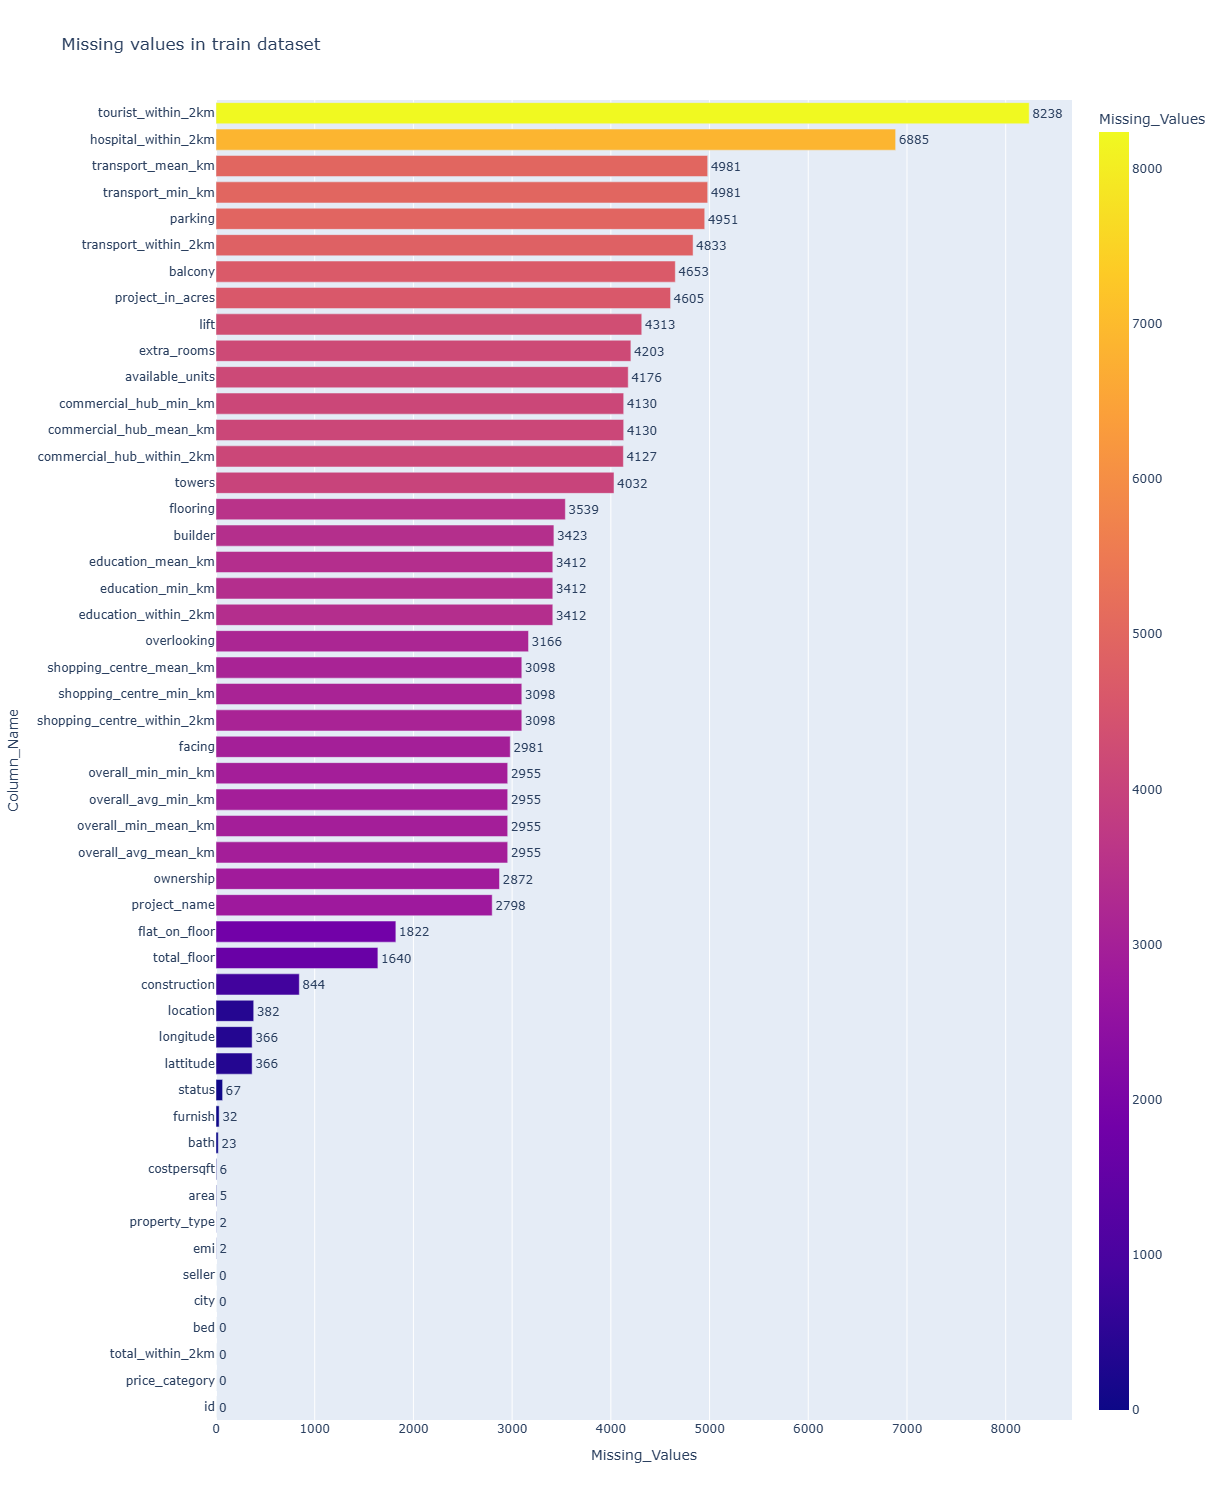

In [23]:
fig = px.bar(temp_X_train.sort_values(by='Missing_Values'),x='Missing_Values',y='Column_Name',
             orientation='h',height=1500,width=1100,color='Missing_Values',text='Missing_Values',title='Missing values in train dataset')
fig.update_traces(textposition='outside')
fig.show()

In [24]:
#First we create a list of missing values by each feature
temp = list(X_test.isna().sum())

#then we create a list of columns and their missing values as inner list to a separate list
lst= []
i=0
for col in X_test.columns:
    insert_lst = [col,temp[i]]
    lst.append(insert_lst)
    i+=1

#finally create a dataframe
temp_X_test = pd.DataFrame(data=lst,columns=['Column_Name','Missing_Values'])

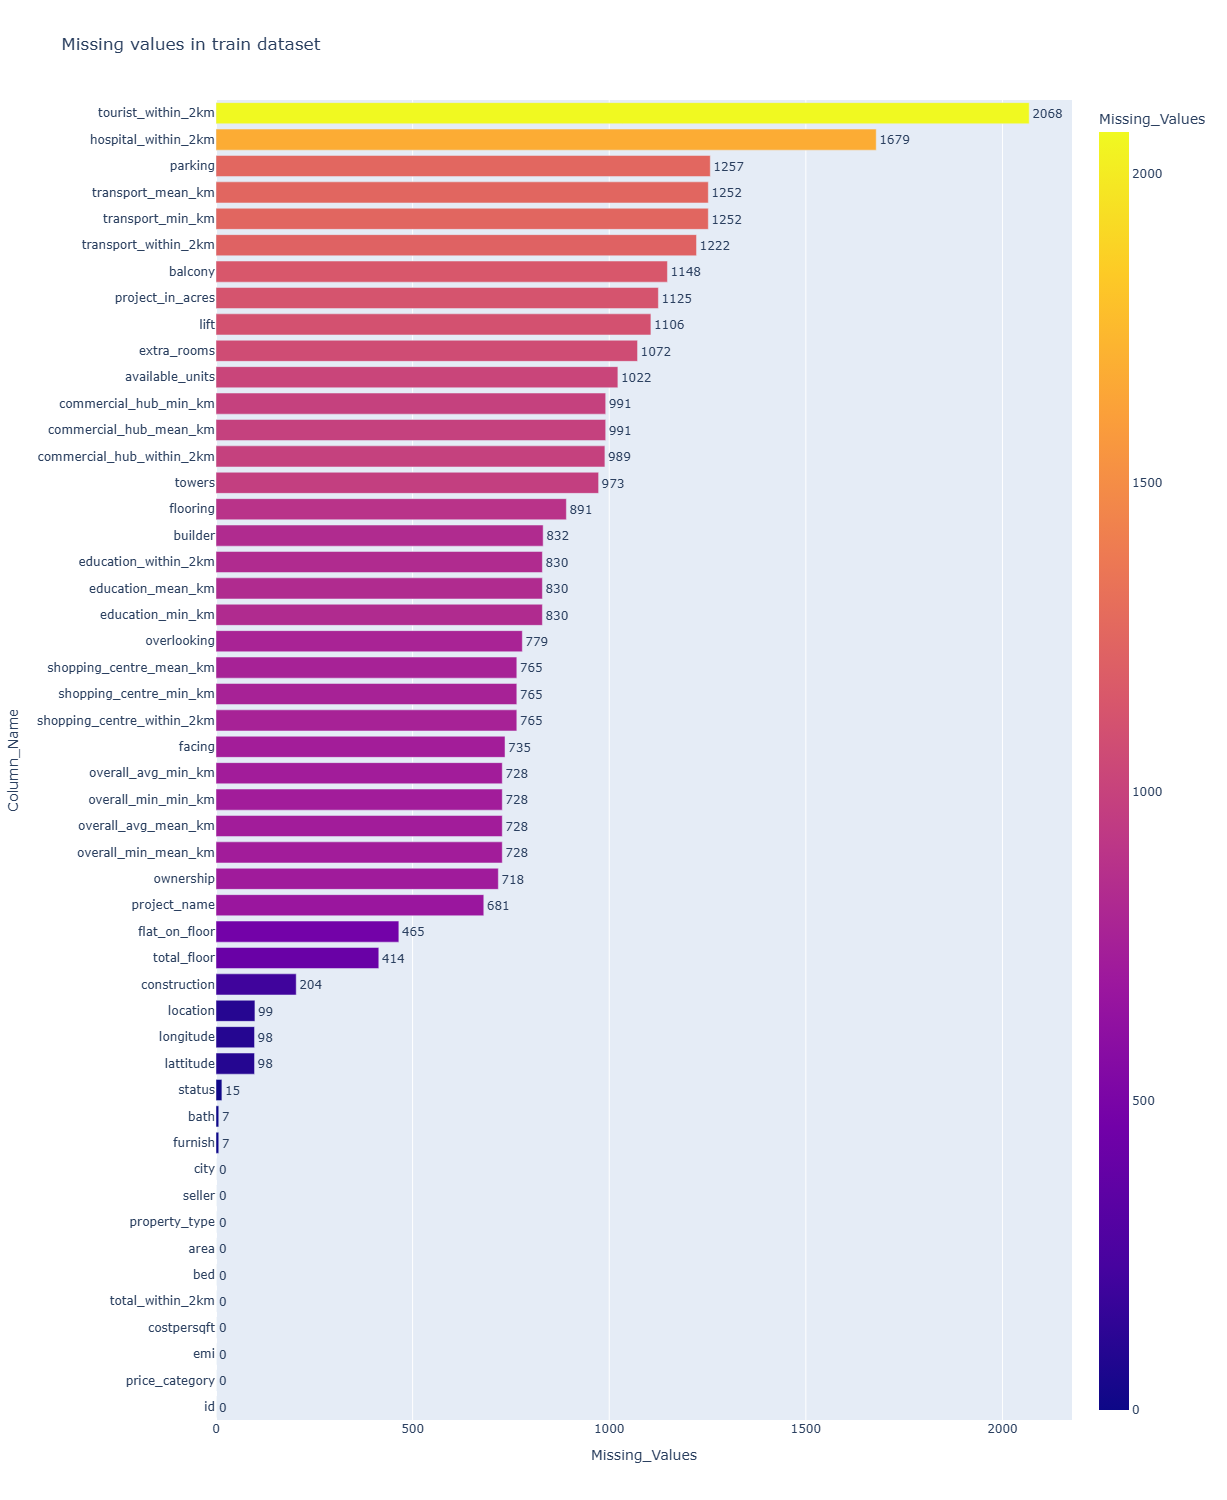

In [25]:
fig = px.bar(temp_X_test.sort_values(by='Missing_Values'),x='Missing_Values',y='Column_Name',
             orientation='h',height=1500,width=1100,color='Missing_Values',text='Missing_Values',title='Missing values in train dataset')
fig.update_traces(textposition='outside')
fig.show()

`observation`
- from X_train data total 36 columns have missing values
- from X_test total 33 columns have missing values 

# Diagnosing the Missingness Mechanism

## for numerical columns

### Missingo for Missing Values

In [26]:
X_train.shape

(9485, 50)

<Axes: >

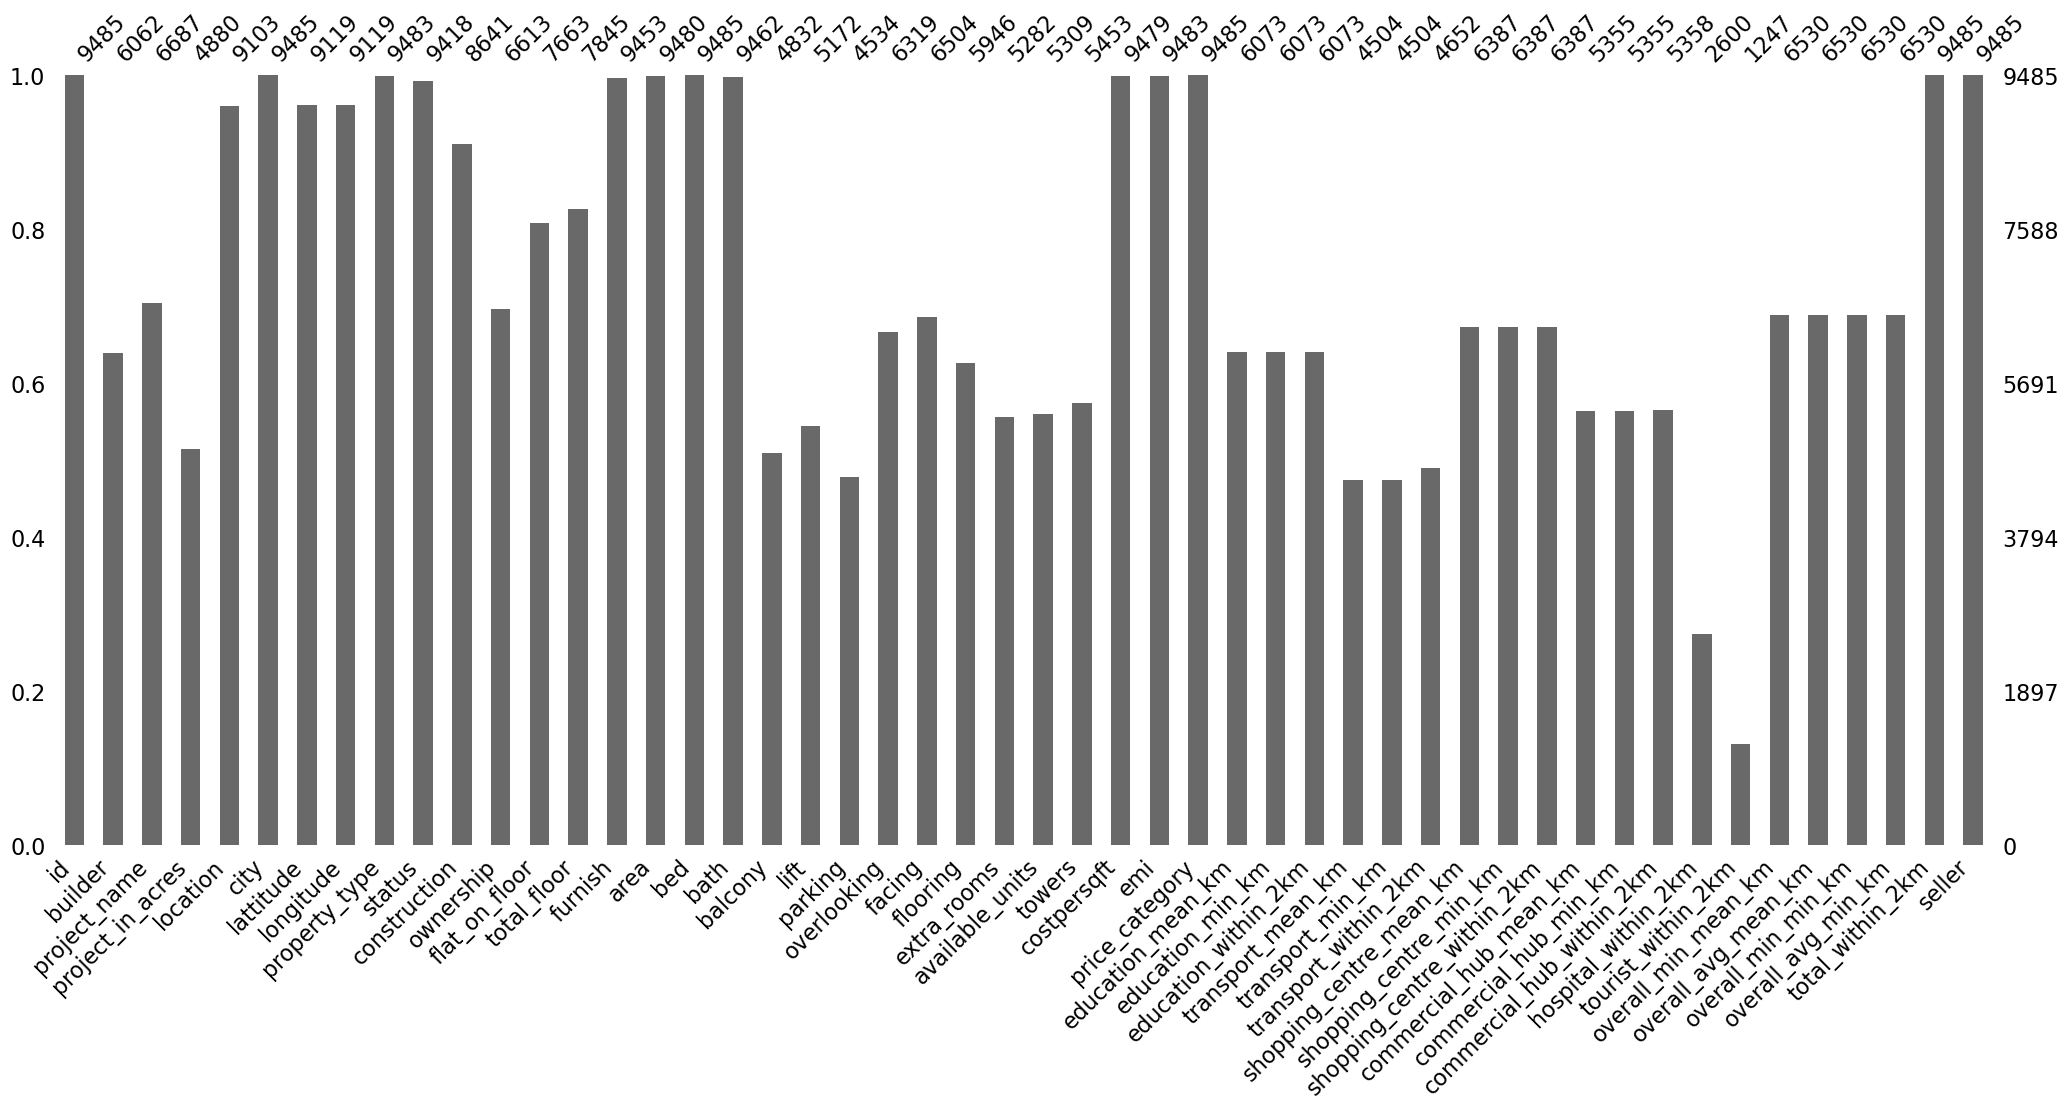

In [27]:
# Bar plot to visualize missing values
msno.bar(X_train)

<Axes: >

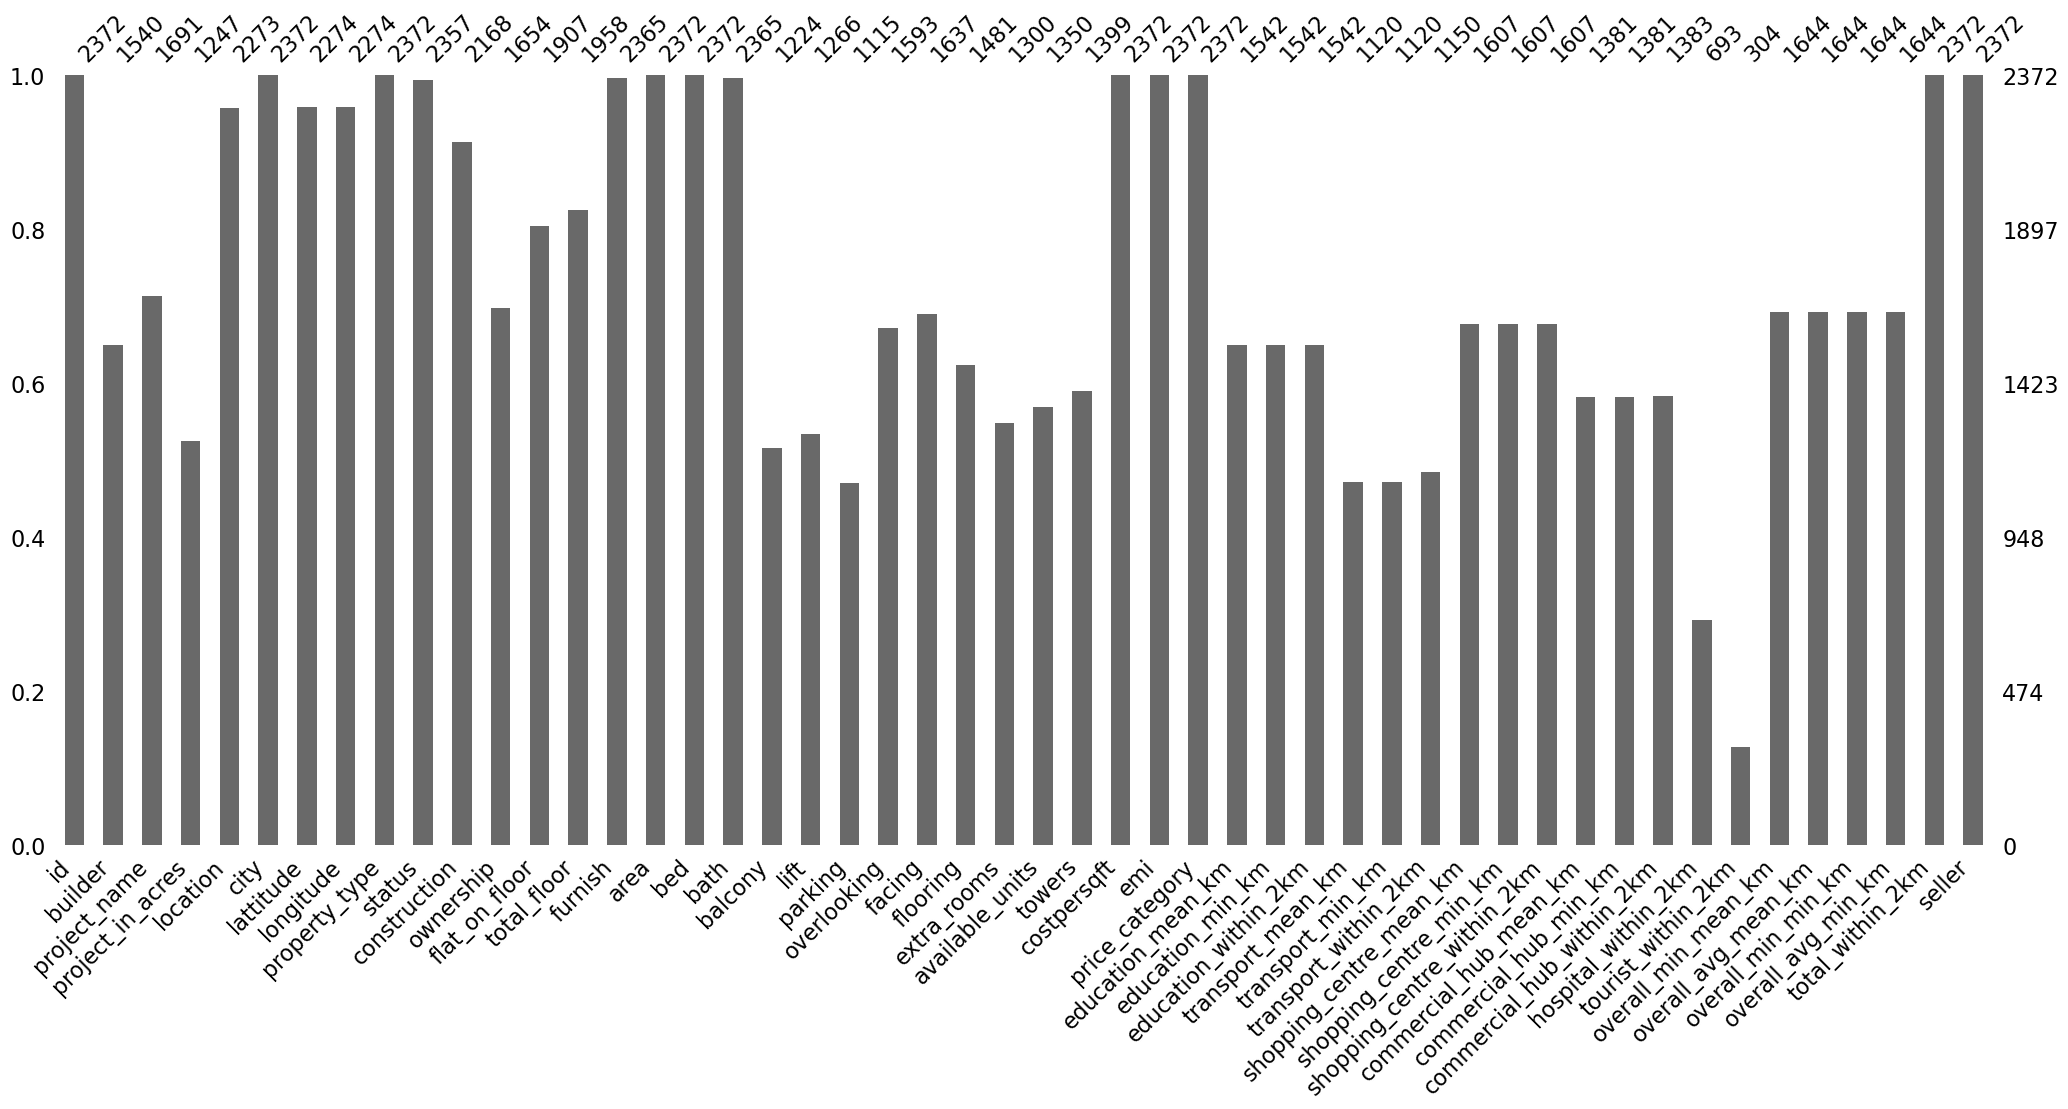

In [28]:
# Bar plot to visualize missing values
msno.bar(X_test)

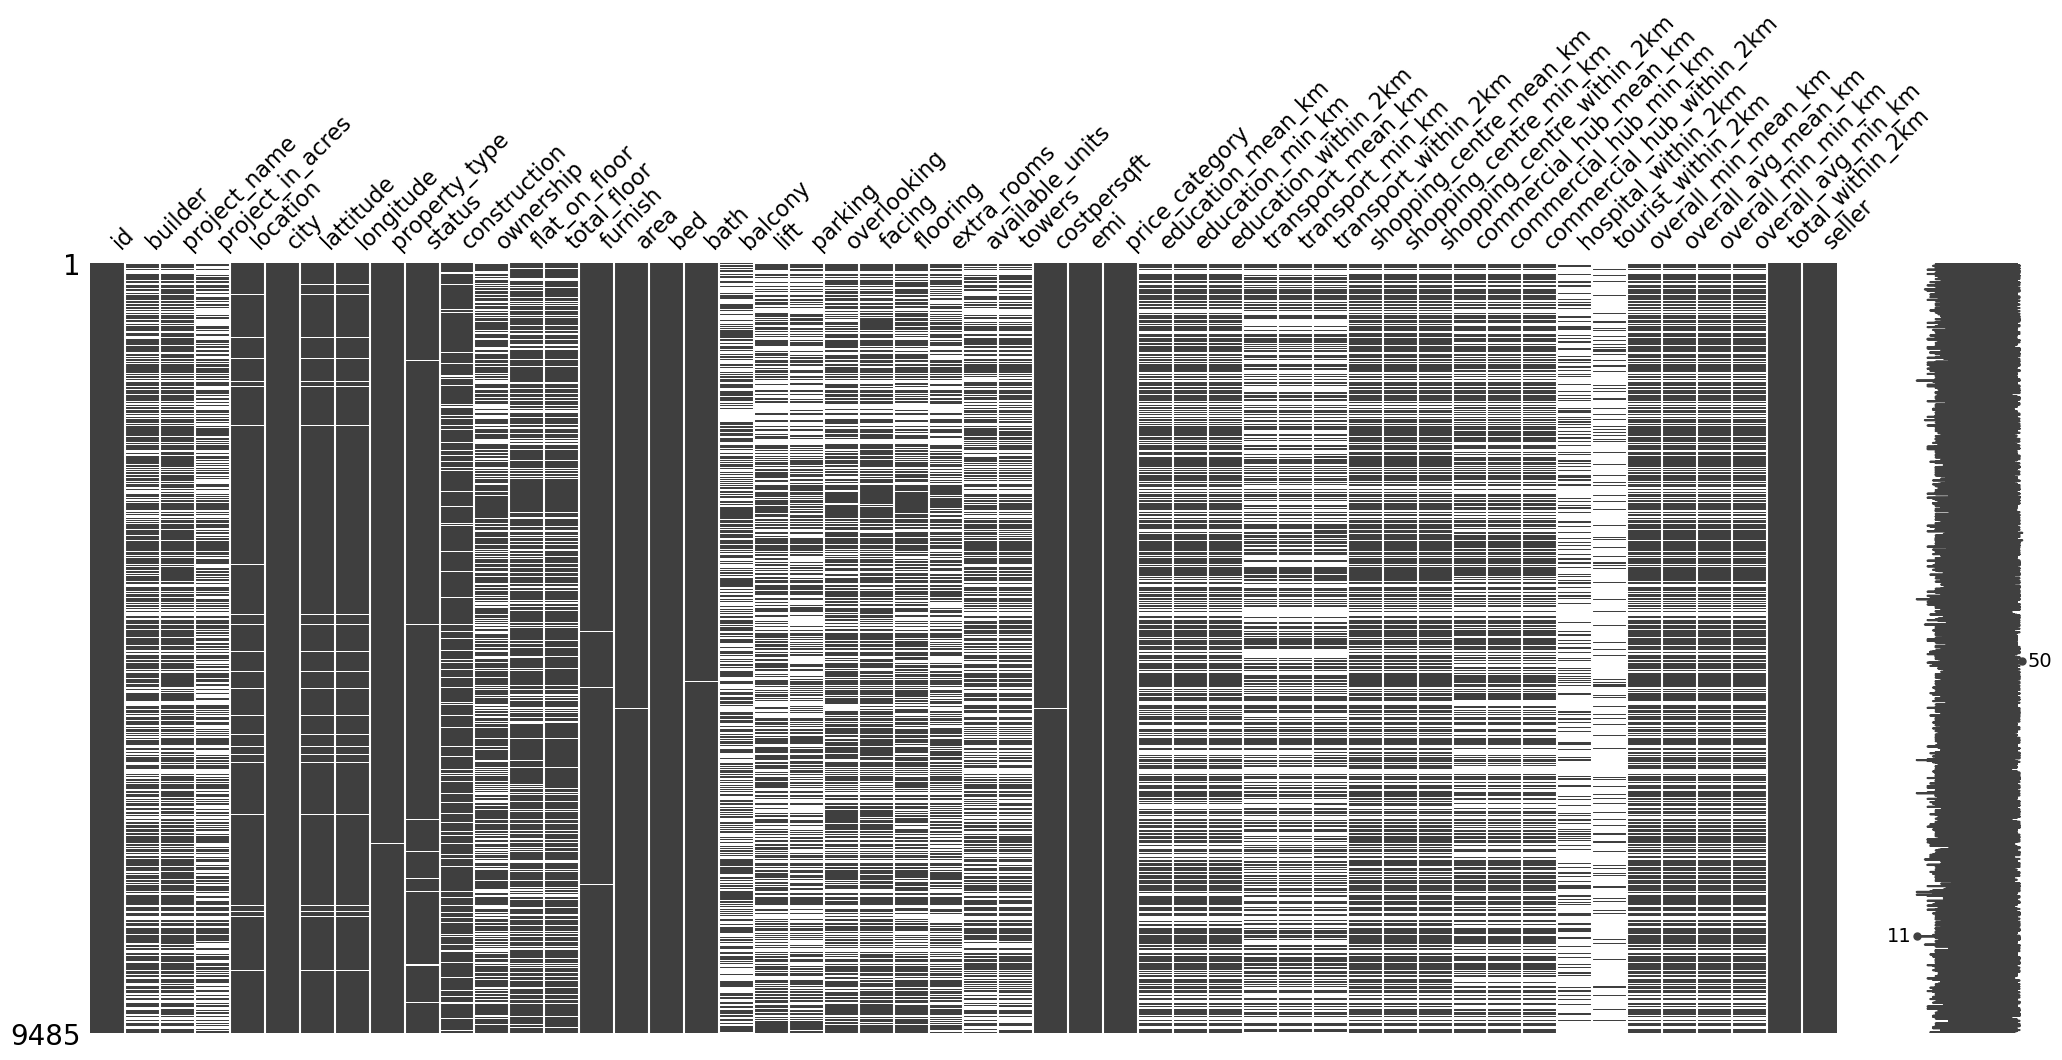

In [29]:
# Matrix chart to visualize missing values
msno.matrix(X_train)
plt.show()

`observation`
- The numbers 44 and 14 show that those rows contain 44 and 14 non-missing values, respectively.
- The white spaces indicate missing values.The black spaces represent present (non-missing) values.
- out of 45 columns 22 columns have major mising values 

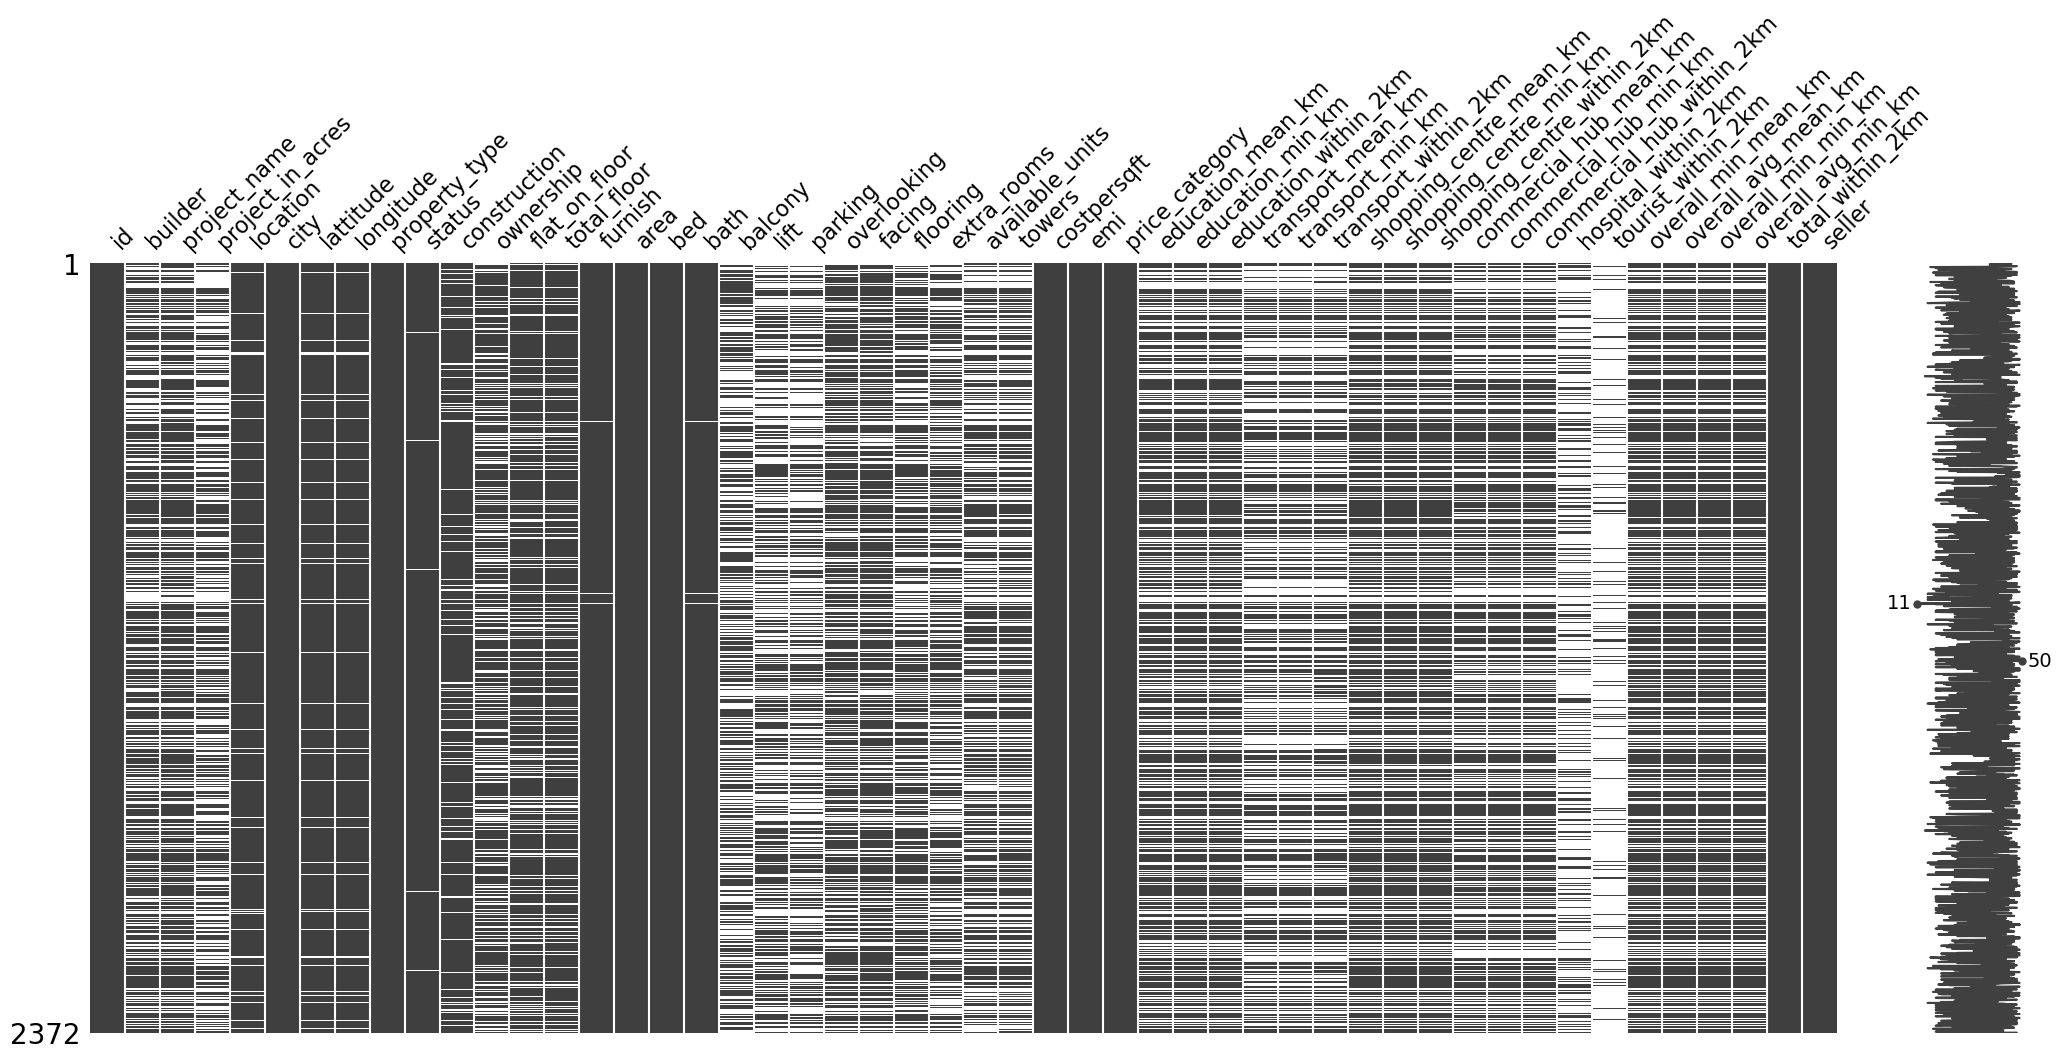

In [30]:
# Matrix chart to visualize missing values
msno.matrix(X_test)
plt.show()

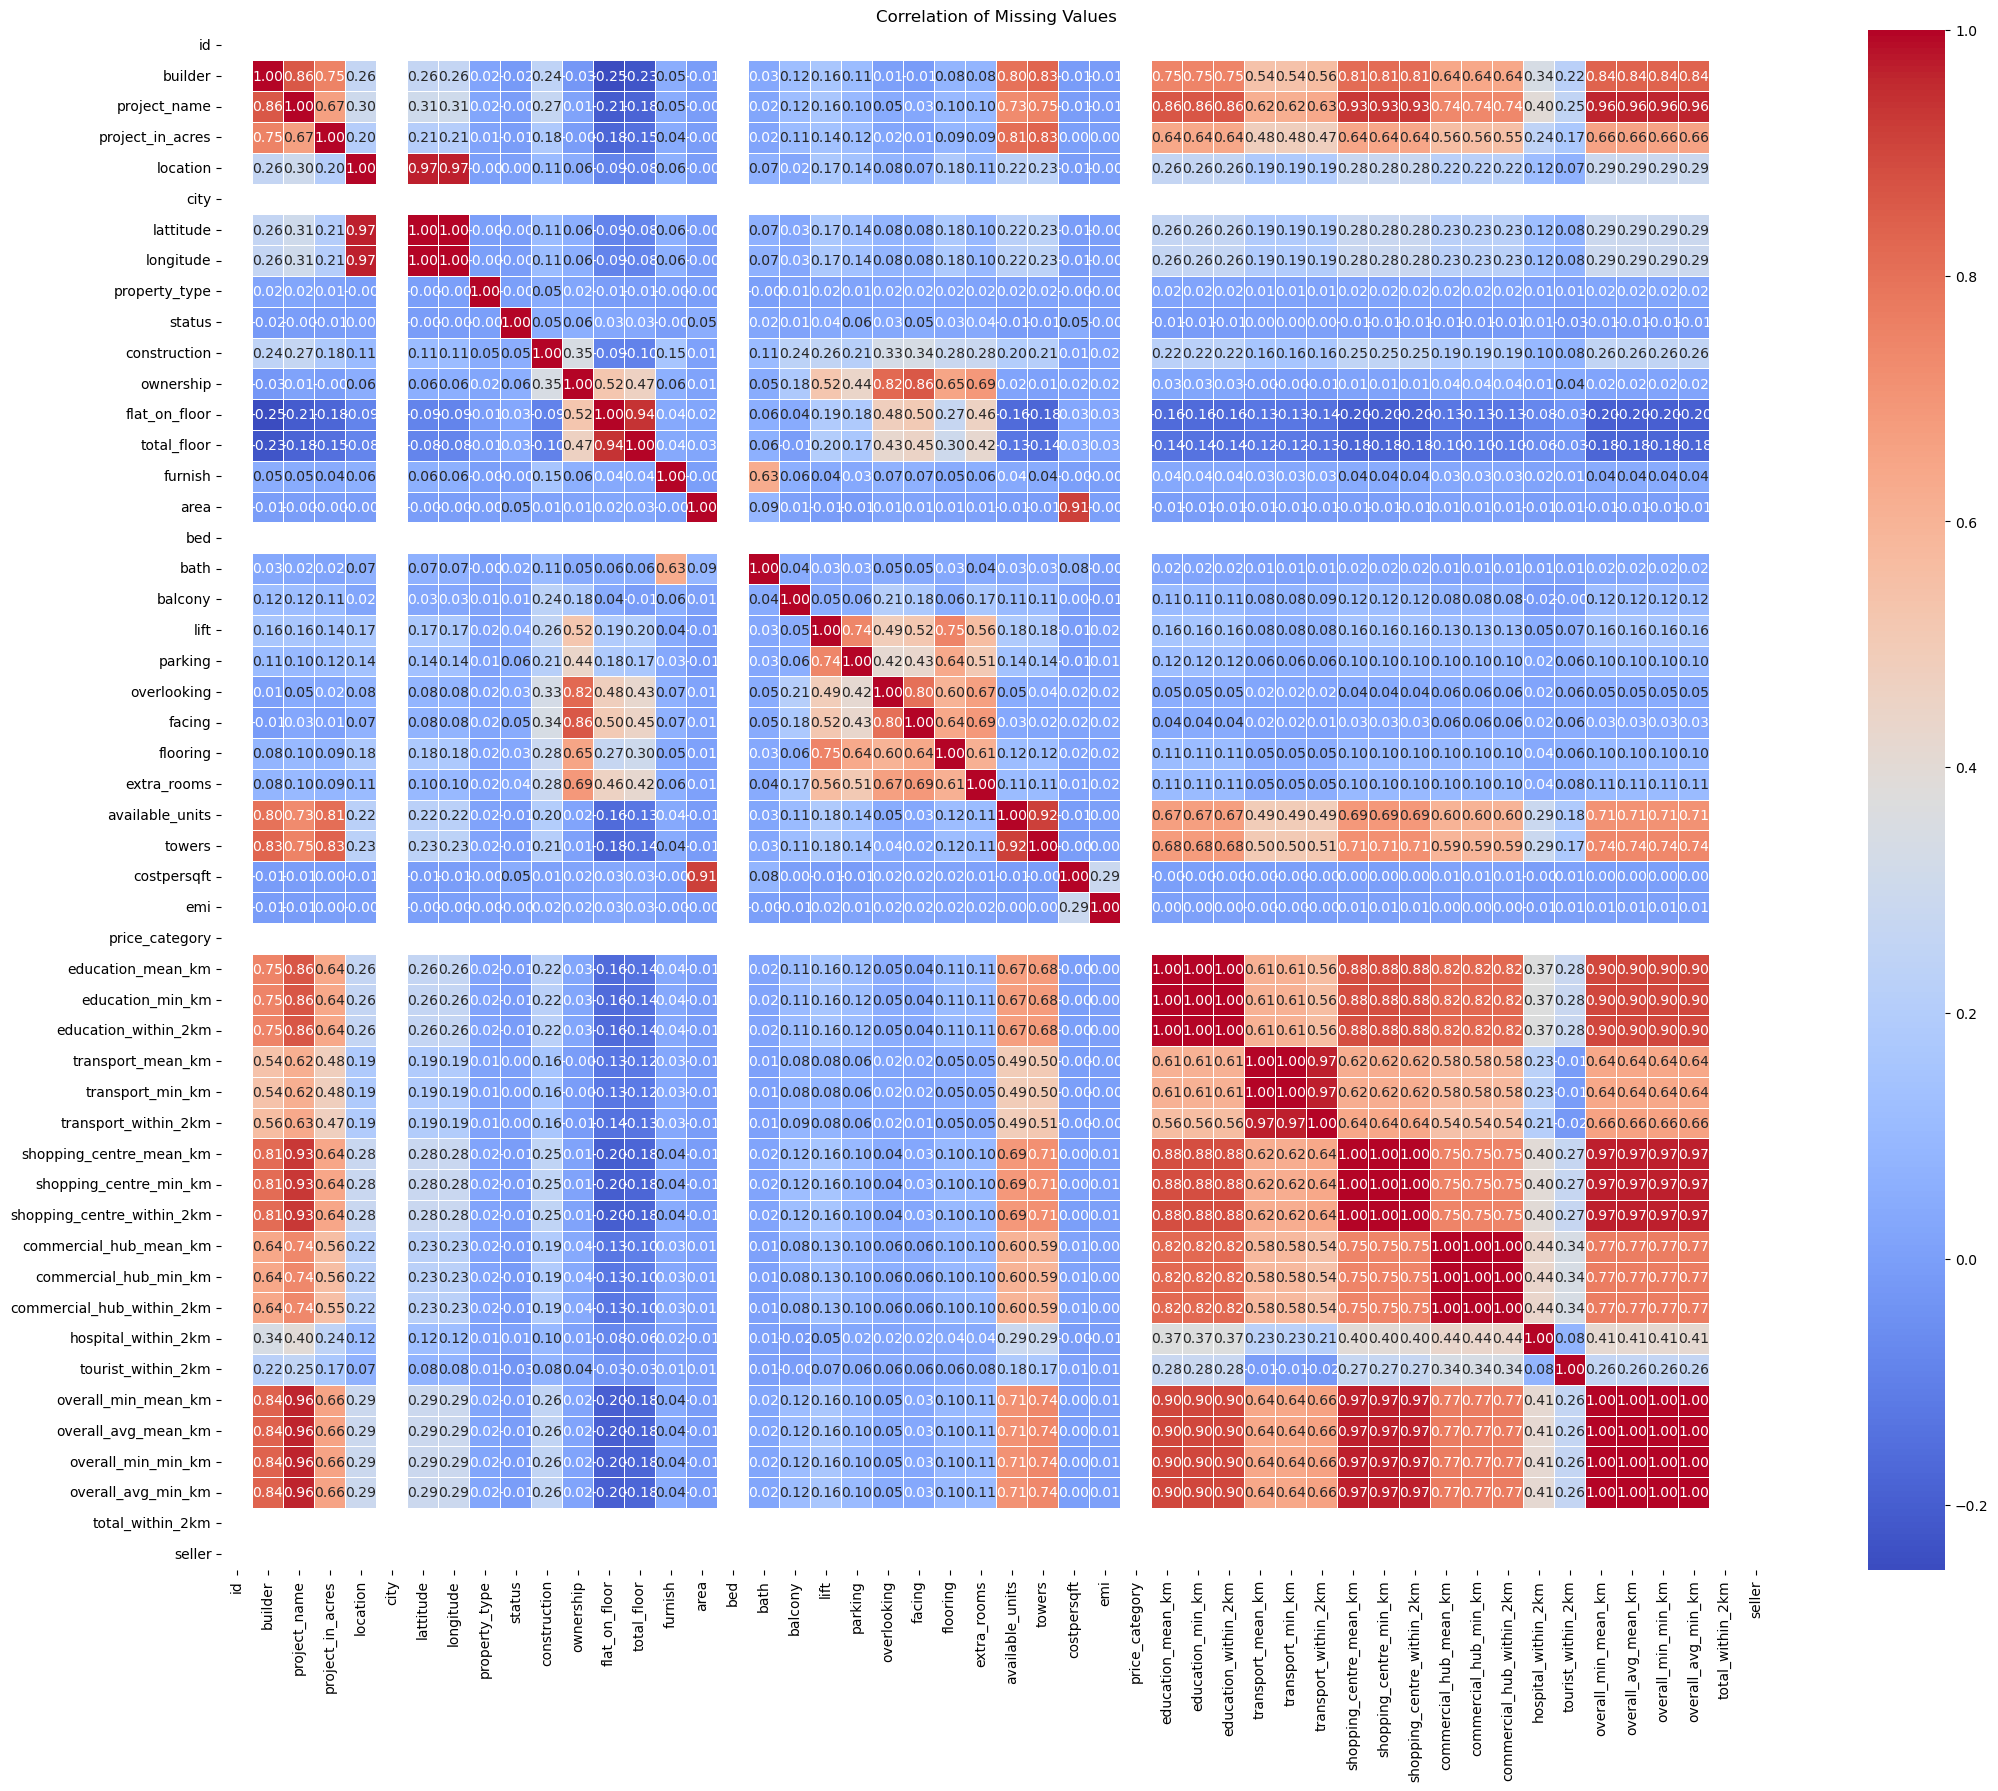

In [31]:
# Compute the missingness correlation
X_train_missing_corr_matrix = X_train.isnull().corr()

plt.figure(figsize=(25,20))
sns.heatmap(X_train_missing_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation of Missing Values")
plt.show()

In [32]:
# Get categorized missing value relationships for X_train data 
missingness_categories = categorize_missingness(X_train_missing_corr_matrix)

# Print results
for category, related_columns in missingness_categories.items():
    print(f"\n{category}:")
    for col, related in related_columns.items():
        print(f"{col}: {', '.join(related)}")


exact 1.00 means always Missing Together:
lattitude: longitude
education_mean_km: education_min_km, education_within_2km
education_min_km: education_within_2km
transport_mean_km: transport_min_km
shopping_centre_mean_km: shopping_centre_min_km, shopping_centre_within_2km
shopping_centre_min_km: shopping_centre_within_2km
commercial_hub_mean_km: commercial_hub_min_km
overall_min_mean_km: overall_avg_mean_km, overall_min_min_km, overall_avg_min_km
overall_avg_mean_km: overall_min_min_km, overall_avg_min_km
overall_min_min_km: overall_avg_min_km

less than 1.00 but greater than equal to 0.7 means highly Likely to be Missing Together:
builder: project_name, project_in_acres, available_units, towers, education_mean_km, education_min_km, education_within_2km, shopping_centre_mean_km, shopping_centre_min_km, shopping_centre_within_2km, overall_min_mean_km, overall_avg_mean_km, overall_min_min_km, overall_avg_min_km
project_name: available_units, towers, education_mean_km, education_min_km, e

`observation`
- "Unrelated Missingness" means that the missing values in two columns have no meaningful relationship.

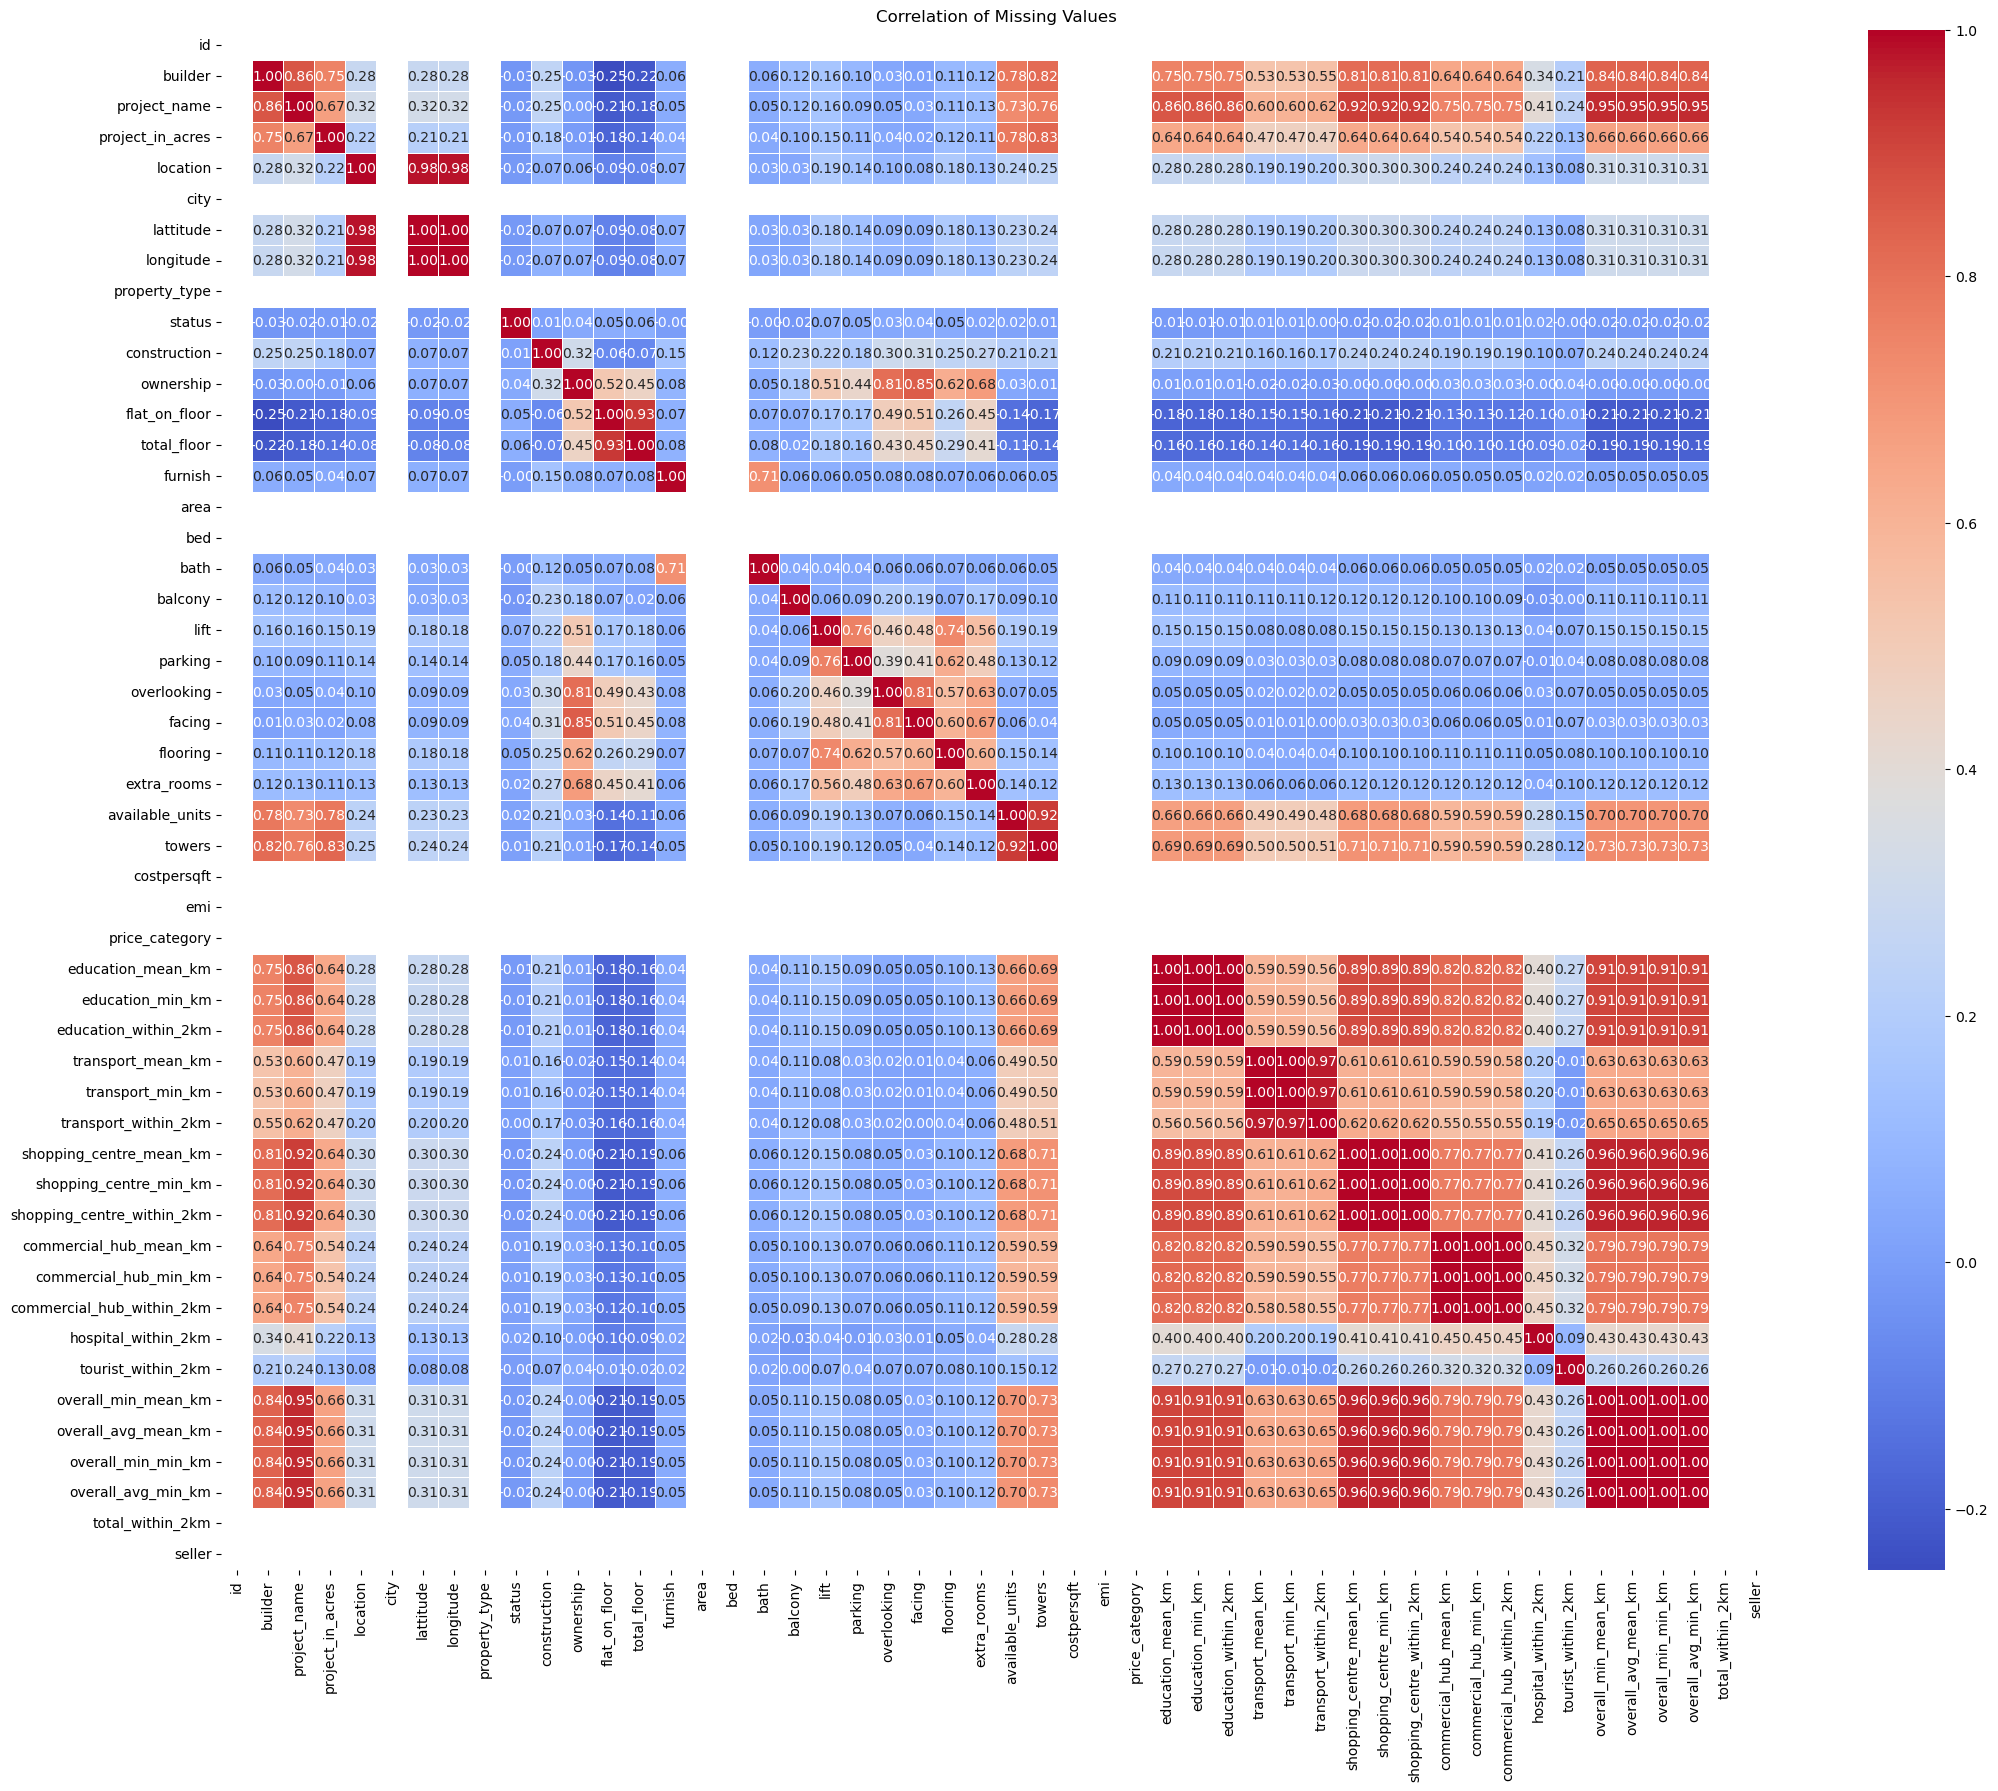

In [33]:
# Compute the missingness correlation
X_test_missing_corr_matrix = X_test.isnull().corr()

plt.figure(figsize=(25,20))
sns.heatmap(X_test_missing_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation of Missing Values")
plt.show()

In [34]:
# Get categorized missing value relationships for X_test data 
missingness_categories = categorize_missingness(X_test_missing_corr_matrix)

# Print results
for category, related_columns in missingness_categories.items():
    print(f"\n{category}:")
    for col, related in related_columns.items():
        print(f"{col}: {', '.join(related)}")


exact 1.00 means always Missing Together:
lattitude: longitude
education_mean_km: education_min_km, education_within_2km
education_min_km: education_within_2km
transport_mean_km: transport_min_km
shopping_centre_mean_km: shopping_centre_min_km, shopping_centre_within_2km
shopping_centre_min_km: shopping_centre_within_2km
commercial_hub_mean_km: commercial_hub_min_km
overall_min_mean_km: overall_avg_mean_km, overall_min_min_km, overall_avg_min_km
overall_avg_mean_km: overall_min_min_km, overall_avg_min_km
overall_min_min_km: overall_avg_min_km

less than 1.00 but greater than equal to 0.7 means highly Likely to be Missing Together:
builder: project_name, project_in_acres, available_units, towers, education_mean_km, education_min_km, education_within_2km, shopping_centre_mean_km, shopping_centre_min_km, shopping_centre_within_2km, overall_min_mean_km, overall_avg_mean_km, overall_min_min_km, overall_avg_min_km
project_name: available_units, towers, education_mean_km, education_min_km, e

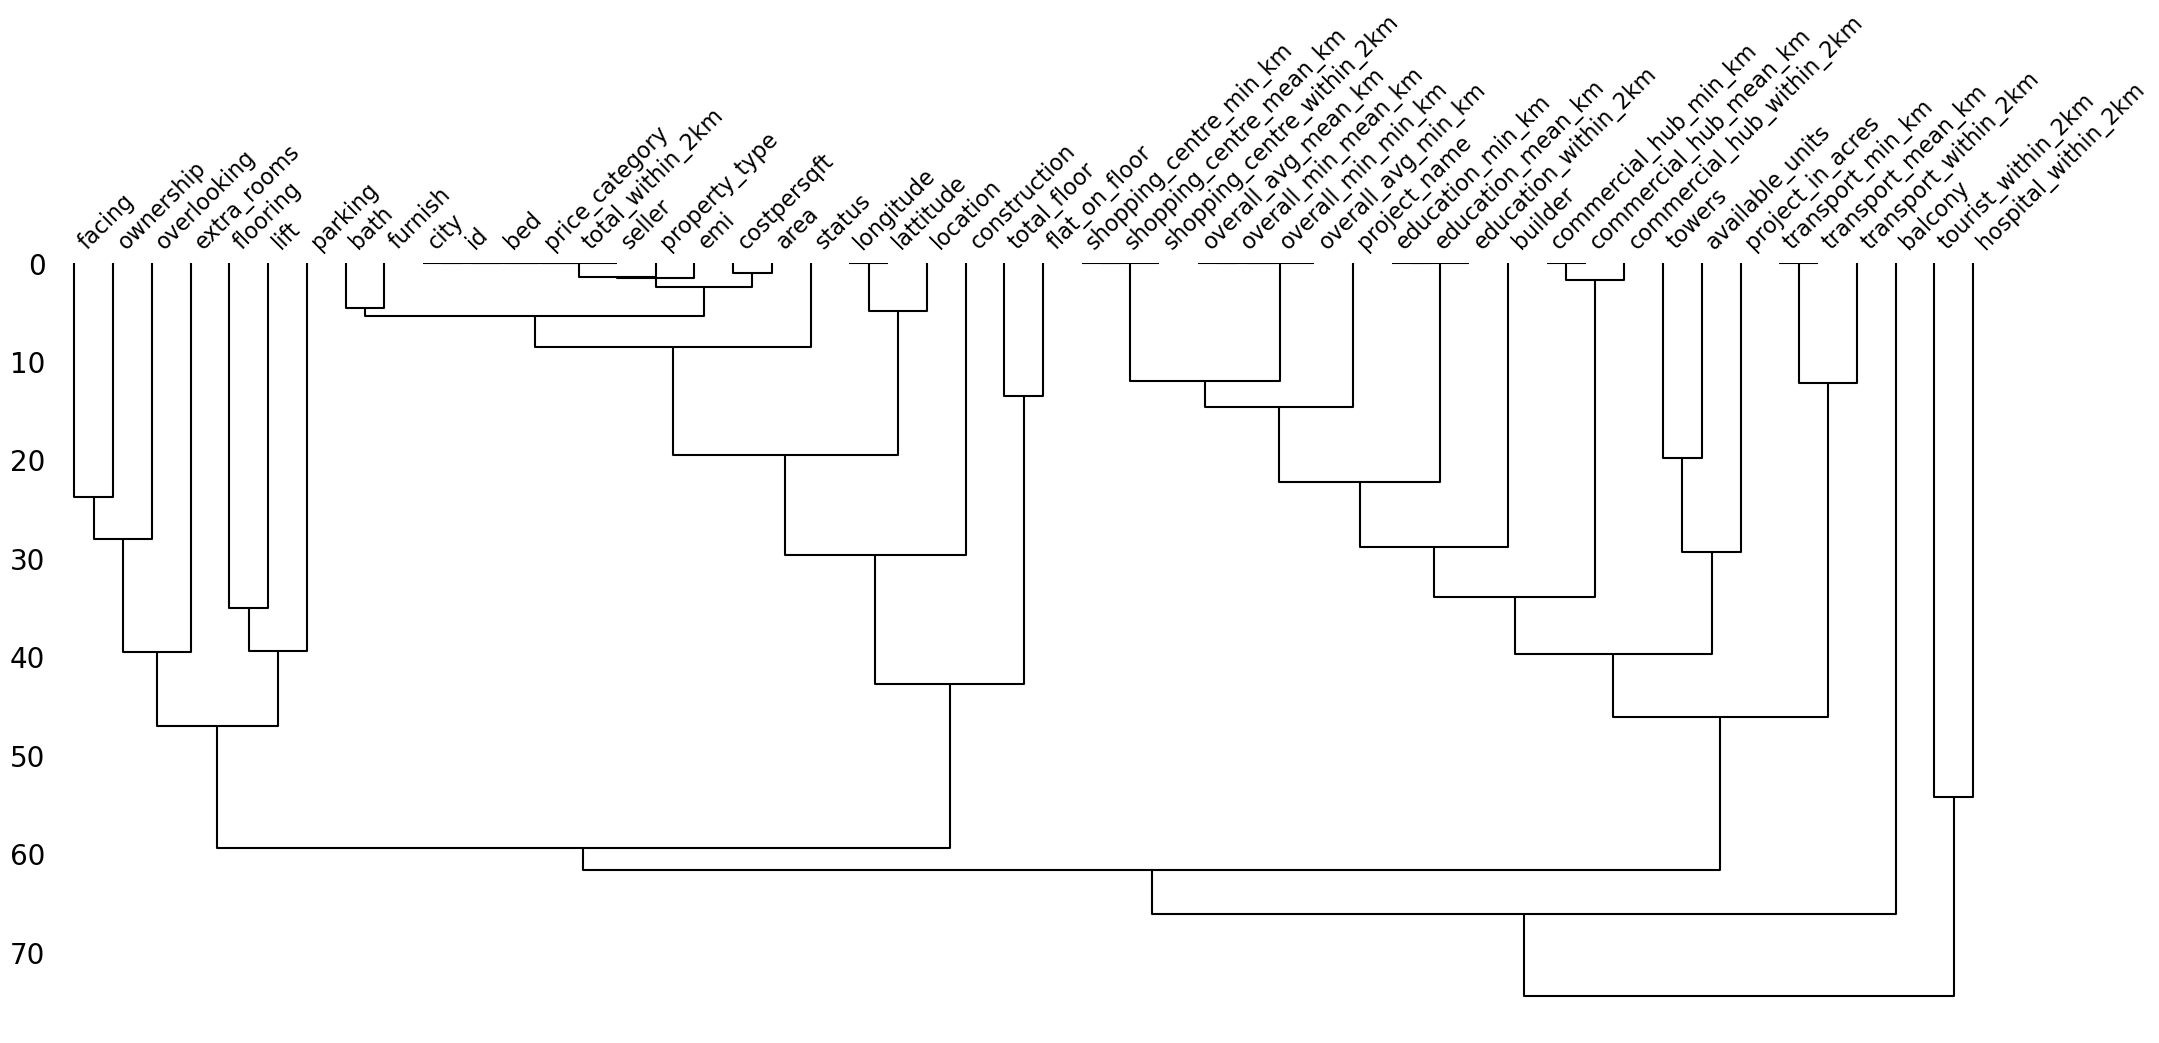

In [35]:
# Dendrogram to visualize the hierarchical clustering of missing values
msno.dendrogram(X_train)
plt.show()

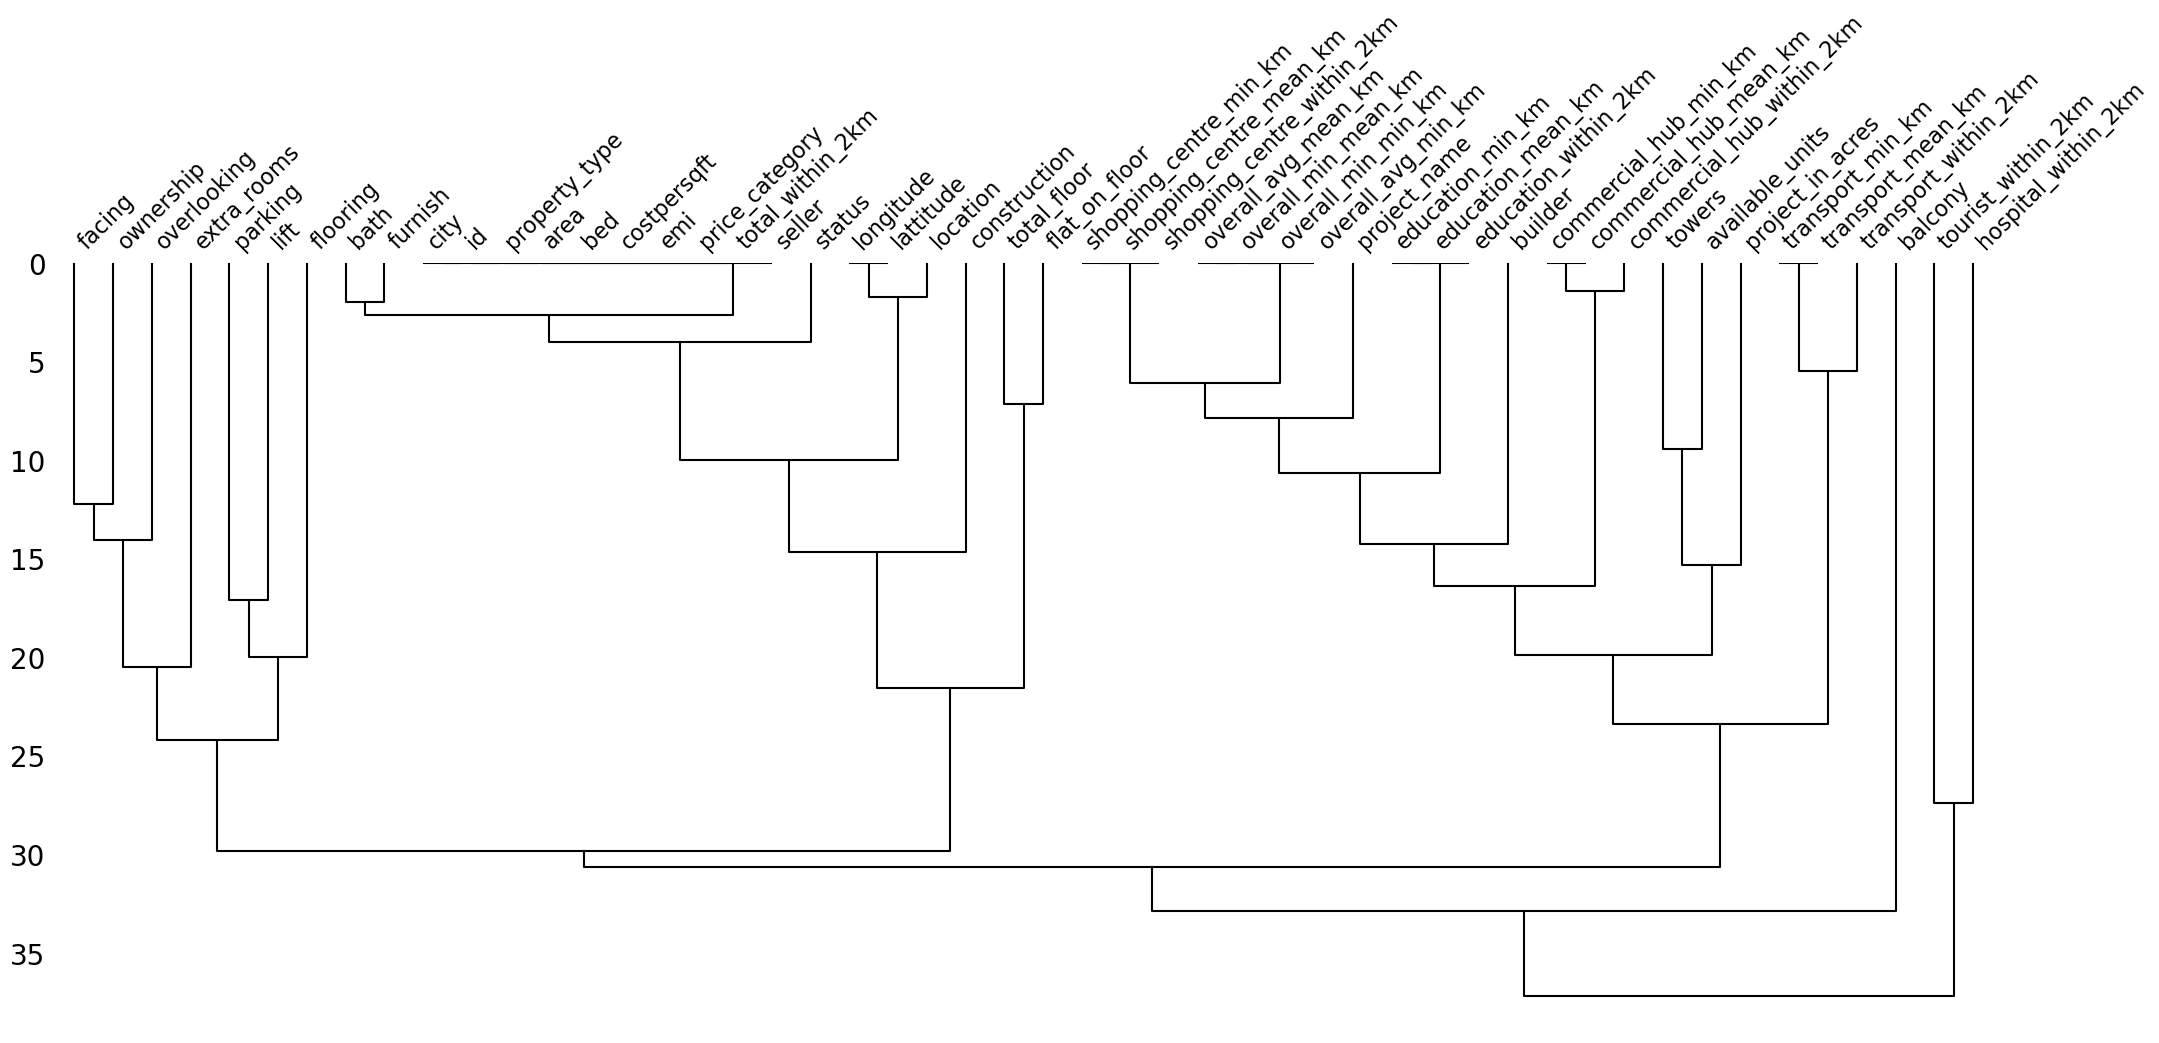

In [36]:
# Dendrogram to visualize the hierarchical clustering of missing values
msno.dendrogram(X_test)
plt.show()

`observation`
- from dendograms we can say that this categorize_missingness function works well 

`notes`  
- **MCAR (Missing Completely at Random):**  
  - Probability of missing data does not depend on observed or unobserved data.  
  - Outcome: If we remove missing values from an MCAR column, the distribution before and after removal remains the same, meaning their absence doesn’t bias the data.  
  - Handling: We can use removal, imputation, or algorithms that handle missing data.
  - Use Little’s MCAR test to statistically verify if data is MCAR.  
- **MAR (Missing at Random):**  
  - Probability of missing data depends on observed data but not on unobserved data.  
  - Handling: Use imputation or algorithms that handle missing values.
  - use KDE plot to detect MAR
- **MNAR (Missing Not at Random):**  
  - Probability of missing data depends on unobserved data, meaning the missingness is related to the actual missing values.  
  - Handling: If we cannot confirm whether data is MCAR or MAR, we assume it could be MNAR.
- **Techniques to Handle Missing Values:**  
  1. Removing: Drop missing values (use only if missingness is small & MCAR).  
  2. Imputation: Fill missing values (various techniques exist).  
  3. Using algorithms that handle missing values natively: E.g., XGBoost, LightGBM.  
  4. Choosing appropriate imputation methods:  
     - Continuous data: Mean, median, regression-based imputation.  
     - Categorical data: Mode, predictive modeling, category-specific imputation.    
- **Key Point:**  
  - Preserve the data distribution before and after handling missing values to avoid bias.
  - If we drop the missing value rows of any column then to check for categorical data we use PMF method 

`observation`
- Drop columns with too many missing values (e.g., >50%).
- Since columns are MCAR with <5% missing data, removing rows won’t bias the distribution, making it an acceptable choice over imputation.
- so in X_train data 9 columns have more than 40% missing values 
- so I wont drop them yet as I plan to create a new features from them

`observation`  
Missing Value Analysis

- use Little’s MCAR test to distinguish between MAR, MCAR, and MNAR.
- Use correlation analysis to check if missing values are dependent on other features (MAR).
- For MNAR, check if missingness correlates with the target variable.

In [37]:
#find the numerical columns
numerical_columns = X_train.select_dtypes(include=['number']).columns
print(numerical_columns)
print("-"*100)
print(f'total numerical columns : {len(numerical_columns)}')

Index(['project_in_acres', 'lattitude', 'longitude', 'flat_on_floor',
       'total_floor', 'area', 'bed', 'bath', 'balcony', 'lift', 'parking',
       'available_units', 'towers', 'costpersqft', 'emi', 'education_mean_km',
       'education_min_km', 'education_within_2km', 'transport_mean_km',
       'transport_min_km', 'transport_within_2km', 'shopping_centre_mean_km',
       'shopping_centre_min_km', 'shopping_centre_within_2km',
       'commercial_hub_mean_km', 'commercial_hub_min_km',
       'commercial_hub_within_2km', 'hospital_within_2km',
       'tourist_within_2km', 'overall_min_mean_km', 'overall_avg_mean_km',
       'overall_min_min_km', 'overall_avg_min_km', 'total_within_2km'],
      dtype='object')
----------------------------------------------------------------------------------------------------
total numerical columns : 34


### t-tests for all numeric predictors.
only did here for numerical columns 

**Suppose we take the `feature 1` column:**

 * The data is divided into two groups:

   1. Rows where `feature1` is **missing**
   2. Rows where `feature1` is **not missing**
 * For each group, we calculate the **mean of all numerical columns**.
 * Then, we compare these means to see how much the other features differ between the missing and non-missing groups for `feature1`.

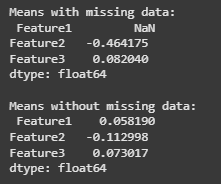

`Observation`  
- in 1st group Feature1 has no mean for the missing group (because it’s the column you split on).  
- Feature2 is much lower when data is missing (-0.46 vs. -0.11) → shows a clear difference.  
- Feature3 is slightly higher when data is missing (0.08 vs. 0.07) → small difference.  
- So, the missingness in Feature1 is related to Feature2 the most.

Meaning:  
hence Feature1 is likely MAR because its missingness depends on another feature (Feature2).

In [38]:
# Analyze column
analyze_missing_column(X_train, 'balcony')

Means with 'balcony' missing:
 project_in_acres                 14.441832
lattitude                        19.145326
longitude                        72.896927
flat_on_floor                     9.835010
total_floor                      20.334887
area                            766.208602
bed                               1.989254
bath                              2.142487
balcony                                NaN
lift                              3.001242
parking                           1.259330
available_units                 412.178298
towers                            4.113466
costpersqft                   27651.901970
emi                               1.104257
education_mean_km                 7.739559
education_min_km                  2.000000
education_within_2km              1.829733
transport_mean_km                 3.900454
transport_min_km                  2.412976
transport_within_2km              1.226461
shopping_centre_mean_km           3.121706
shopping_centre_min_km 

In [49]:
# Analyze column with all other numerical columns
analyze_missing_column_with_all_predictors(X_train, 'available_units')


T-test for 'project_in_acres':
T-statistic: 1.2428, P-value: 0.2142
=> 'project_in_acres' is NOT significantly different: 'available_units' likely MCAR.

T-test for 'lattitude':
T-statistic: 5.3479, P-value: 0.0000
=> 'lattitude' is significantly different: 'available_units' likely MAR.

T-test for 'longitude':
T-statistic: 1.7589, P-value: 0.0786
=> 'longitude' is NOT significantly different: 'available_units' likely MCAR.

T-test for 'flat_on_floor':
T-statistic: -29.6345, P-value: 0.0000
=> 'flat_on_floor' is significantly different: 'available_units' likely MAR.

T-test for 'total_floor':
T-statistic: -42.5133, P-value: 0.0000
=> 'total_floor' is significantly different: 'available_units' likely MAR.

T-test for 'area':
T-statistic: -14.5932, P-value: 0.0000
=> 'area' is significantly different: 'available_units' likely MAR.

T-test for 'bed':
T-statistic: -18.9520, P-value: 0.0000
=> 'bed' is significantly different: 'available_units' likely MAR.

T-test for 'bath':
T-statistic: 

`observation`
- put 1 numerical feature at a time in 'analyze_missing_column_with_all_predictors' to check how many MCAR and how many MAR counts are there eg:Suppose we take 'bed' feature and for that we get more MAR count than MCAR then we can say that the bed column is MAR 
- If a column is MCAR, removing rows with NaNs does not affect other columns’ distributions. But if the column is MAR, removing rows with NaNs does affect other columns’ distributions.
- Little’s MCAR test provides a global assessment of missingness across all numerical features, whereas t-tests only compare specific variables, making Little’s test more comprehensive. hence further go with only Little MCAR test
- have only done it on numerical columns; for categorical columns, still need to work.

In [40]:
df.columns

Index(['id', 'builder', 'project_name', 'project_in_acres', 'location', 'city',
       'lattitude', 'longitude', 'property_type', 'status', 'construction',
       'ownership', 'flat_on_floor', 'total_floor', 'furnish', 'area', 'bed',
       'bath', 'balcony', 'lift', 'parking', 'overlooking', 'facing',
       'flooring', 'extra_rooms', 'available_units', 'towers', 'costpersqft',
       'emi', 'price_category', 'price', 'education_mean_km',
       'education_min_km', 'education_within_2km', 'transport_mean_km',
       'transport_min_km', 'transport_within_2km', 'shopping_centre_mean_km',
       'shopping_centre_min_km', 'shopping_centre_within_2km',
       'commercial_hub_mean_km', 'commercial_hub_min_km',
       'commercial_hub_within_2km', 'hospital_within_2km',
       'tourist_within_2km', 'overall_min_mean_km', 'overall_avg_mean_km',
       'overall_min_min_km', 'overall_avg_min_km', 'total_within_2km',
       'seller'],
      dtype='object')

### Predictive Modeling for Missingness

- This code checks whether the missingness of 'pattern_for_column' can be predicted using other numeric features.
- If the model predicts 'column_missing' well → the missingness is likely MAR (depends on other features).
- If the model predicts poorly → missingness is likely MCAR or MNAR (not explained by other features).

In [53]:
# Example usage:
missingness_logistic_test(df, pattern_for_column='available_units', drop_columns=['price'])

Missingness pattern for 'available_units':
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      2012
           1       0.87      0.74      0.80      1546

    accuracy                           0.84      3558
   macro avg       0.84      0.82      0.83      3558
weighted avg       0.84      0.84      0.83      3558



`observation`
- So we should keep the price column as it is because if we include that column, it may change the correlation with the target column and affect the output above. So keep it as it is and include only the required columns in pattern_for_column.
- Accuracy or F1 ≤ 50% → MCAR  
  Accuracy or F1 ≥ 60–70% → MAR  
  MNAR needs domain context — can’t confirm from model alone.  
- remember that in above code o/p in support may get less data point becoz we have splitting data in this function 'missingness_logistic_test'

MAR : 'project_in_acres','education_mean_km','education_min_km','education_within_2km','transport_mean_km','transport_min_km','transport_within_2km',
'shopping_centre_mean_km','shopping_centre_min_km','shopping_centre_within_2km','commercial_hub_mean_km', 'commercial_hub_min_km', 'commercial_hub_within_2km', 'hospital_within_2km'  'tourist_within_2km', 'overall_min_mean_km', 'overall_avg_mean_km   'overall_min_min_km', 'overall_avg_min_km', 'total_within_2km'


MCAR : 'area','bed','bath','costpersqft'      
NOT SURE : 'lattitude','lattitude','flat_on_floor','total_floor','available_units','towers'         
not sure but might be consider as MAR as from this 'analyze_missing_column_with_all_predictors' method also we get this as MAR: 'balcony','lift','parking'   

`observation`  
- Predictive Imputation: shopping_centre_min_km, parking, project_in_acres, flat_on_floor, total_floor, balcony, lift (optional), all mean/min km columns
- Simple Imputation : area, bath, costpersqft

`conclusion`
- have work only on numerical columns till now using both this test , categorical columns are still pending

### KDE plots for missingness: MAR or MCAR

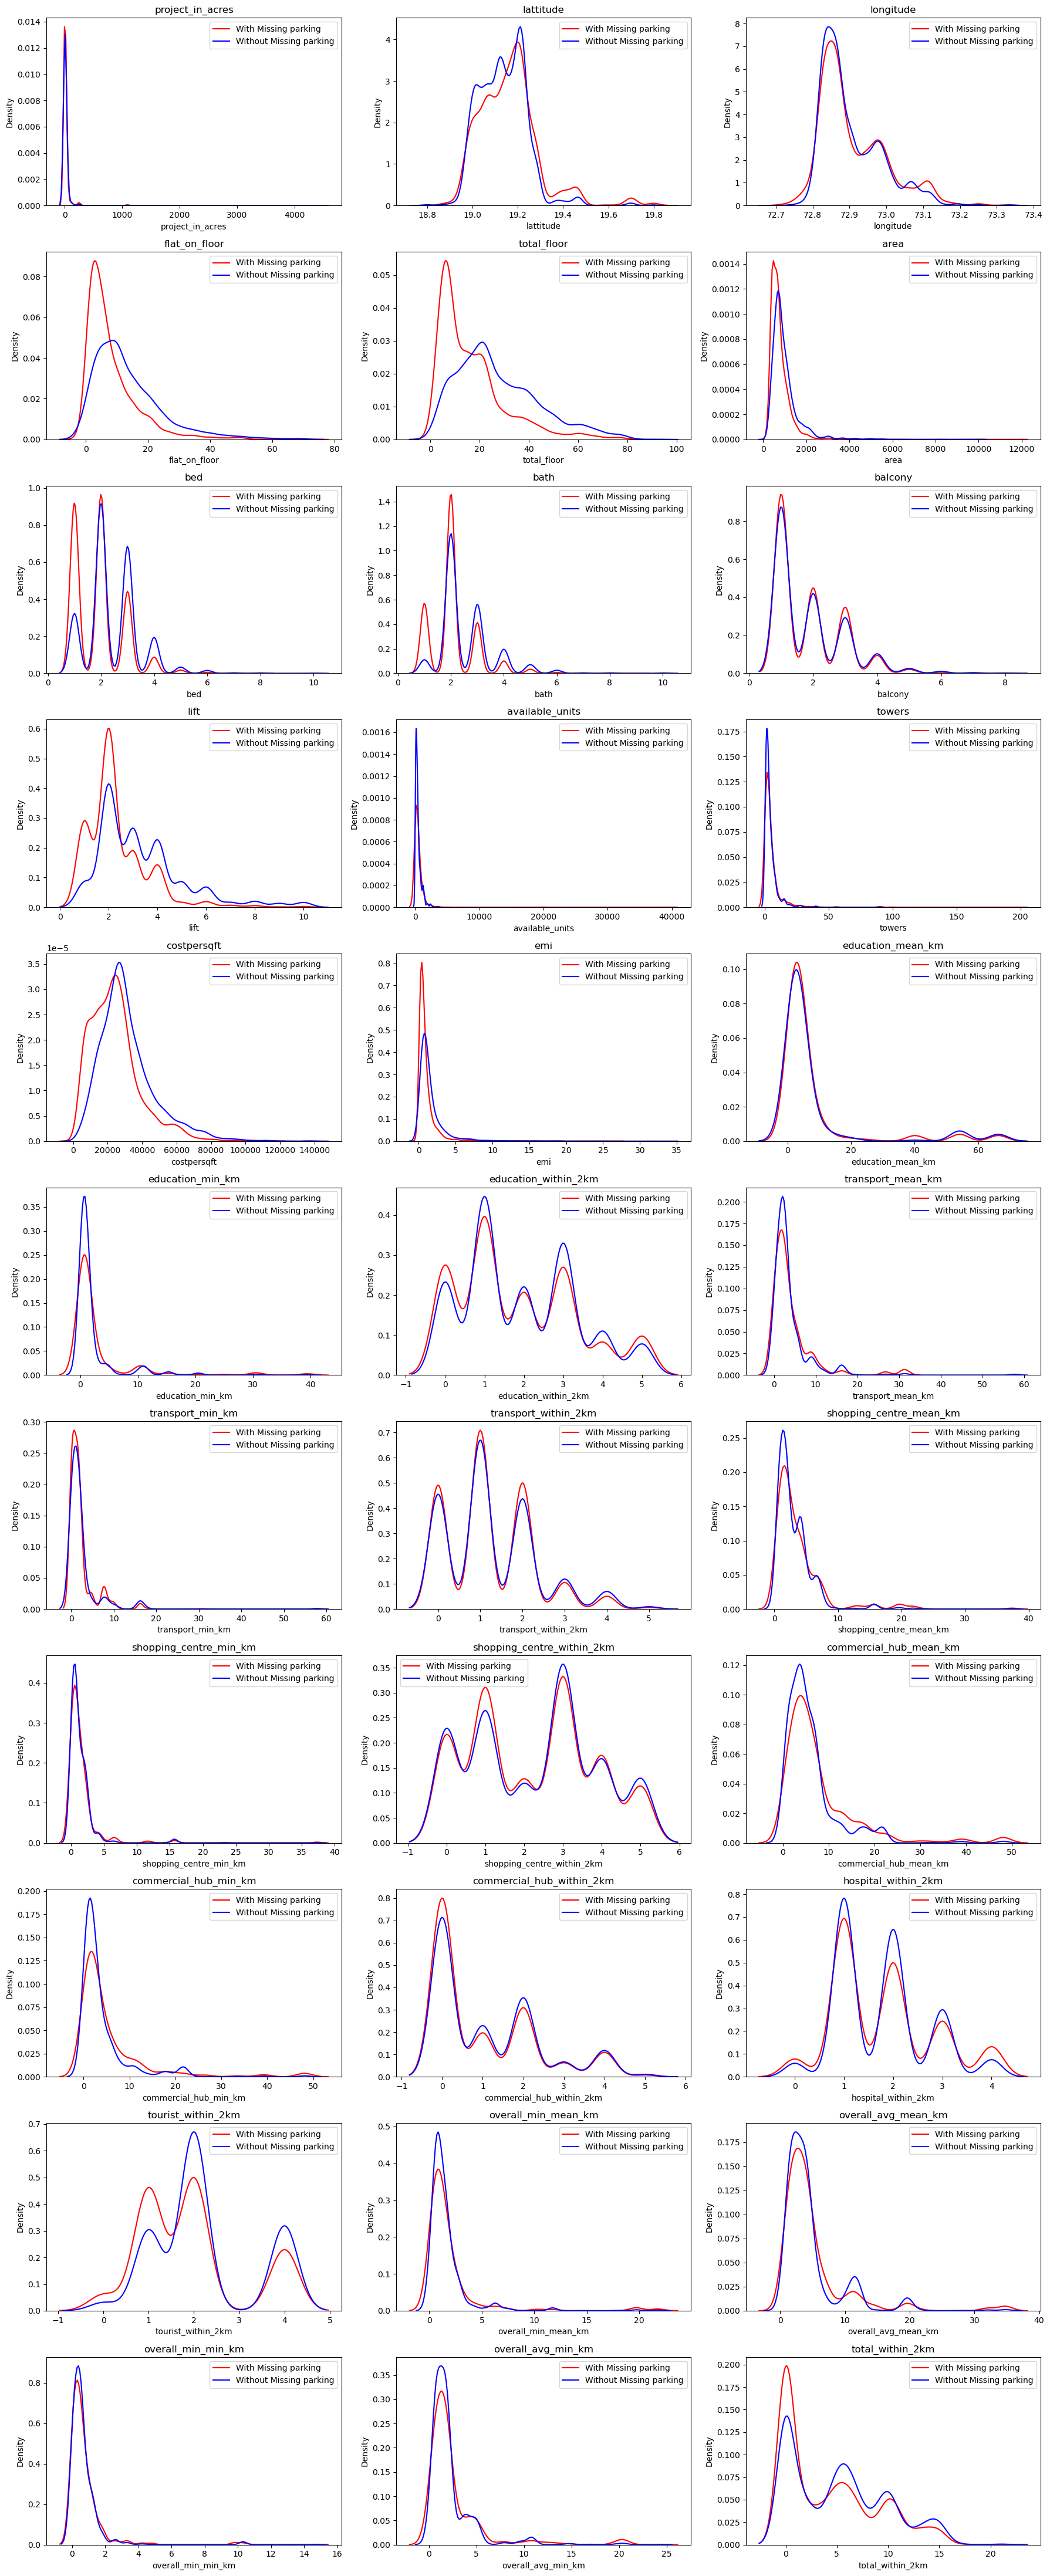

In [42]:
def plot_missingness_kde(df, feature1, num_cols=3):
    # Select only numeric columns
    numeric_features = df.select_dtypes(include=['number']).columns.tolist()

    if feature1 not in numeric_features:
        print(f"Column '{feature1}' is not numeric.")
        return

    if df[feature1].isnull().sum() == 0:
        print(f"'{feature1}' has no missing values.")
        return

    group_with_missing = df[df[feature1].isnull()]
    group_without_missing = df[~df[feature1].isnull()]

    # Other numeric features to plot
    other_features = [col for col in numeric_features if col != feature1]

    num_features = len(other_features)
    num_rows = int(np.ceil(num_features / num_cols))

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(6 * num_cols, 4 * num_rows))
    axes = axes.flatten()

    for i, feature2 in enumerate(other_features):
        sns.kdeplot(
            group_with_missing[feature2].dropna(),
            color='red',
            label=f'With Missing {feature1}',
            common_norm=False,
            ax=axes[i]
        )
        sns.kdeplot(
            group_without_missing[feature2].dropna(),
            color='blue',
            label=f'Without Missing {feature1}',
            common_norm=False,
            ax=axes[i]
        )
        axes[i].set_title(f'{feature2}')
        axes[i].legend()

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()



# Call the function:
plot_missingness_kde(X_train, 'parking')


`observation`
- graphs affected because of removing the outliers and graphs not affected by removing the outliers, both graphs are present for each feature and hence its hard to detect MAR from kde plot also 

`observation`
- Till now out of 4 i.e from 2 analysis(missing and KDE plots) and 2 test(t-test and predictive modeling) we get the good results from `t-tests for all numeric predictors` and `Predictive Modeling for Missingness`

In [43]:
df.columns

Index(['id', 'builder', 'project_name', 'project_in_acres', 'location', 'city',
       'lattitude', 'longitude', 'property_type', 'status', 'construction',
       'ownership', 'flat_on_floor', 'total_floor', 'furnish', 'area', 'bed',
       'bath', 'balcony', 'lift', 'parking', 'overlooking', 'facing',
       'flooring', 'extra_rooms', 'available_units', 'towers', 'costpersqft',
       'emi', 'price_category', 'price', 'education_mean_km',
       'education_min_km', 'education_within_2km', 'transport_mean_km',
       'transport_min_km', 'transport_within_2km', 'shopping_centre_mean_km',
       'shopping_centre_min_km', 'shopping_centre_within_2km',
       'commercial_hub_mean_km', 'commercial_hub_min_km',
       'commercial_hub_within_2km', 'hospital_within_2km',
       'tourist_within_2km', 'overall_min_mean_km', 'overall_avg_mean_km',
       'overall_min_min_km', 'overall_avg_min_km', 'total_within_2km',
       'seller'],
      dtype='object')

## for categorical columns 

### missingness in a categorical column using chi-square test

In [44]:
analyze_missingness_for_categorical(df, 'builder')


Chi-square test for 'id':
Chi2 statistic: 11857.0000, P-value: 0.4957
=> 'id' is NOT significantly related: 'builder' likely MCAR.

Chi-square test for 'project_name':
Chi2 statistic: 8321.5956, P-value: 0.0000
=> 'project_name' is significantly related: 'builder' likely MAR.

Chi-square test for 'location':
Chi2 statistic: 3620.1180, P-value: 0.0000
=> 'location' is significantly related: 'builder' likely MAR.

Chi-square test for 'city':
Chi2 statistic: 213.8958, P-value: 0.0000
=> 'city' is significantly related: 'builder' likely MAR.

Chi-square test for 'property_type':
Chi2 statistic: 1495.5897, P-value: 0.0000
=> 'property_type' is significantly related: 'builder' likely MAR.

Chi-square test for 'status':
Chi2 statistic: 1682.8091, P-value: 0.0000
=> 'status' is significantly related: 'builder' likely MAR.

Chi-square test for 'construction':
Chi2 statistic: 1941.5862, P-value: 0.0000
=> 'construction' is significantly related: 'builder' likely MAR.

Chi-square test for 'owner

`observation`  
MAR : 'builder','project_name','.location','construction','ownership','overlooking','facing','flooring','extra_rooms'  
MCAR : 'property_type','status'  
NOT SURE : 'furnish'

# This code is to be used in a VS Code script.

# missing value imputation function

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
def property_missingness_identification(df):
    #--------------------------------------------------------------------------------------------------------------------------------------------------------------

    #drop more than 70% missing value columns 
    cols_to_drop = ['tourist_mean_km', 'tourist_min_km', 'hospital_mean_km', 'hospital_min_km']
    df = df.drop(columns=cols_to_drop)
    return df

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    

df = property_missingness_identification(df)    